<a href="https://colab.research.google.com/github/oluwaseun-odufisan/Payment-Routing-System/blob/main/Payment_Routing_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

# Installing all required libraries

In [20]:
!pip install pandas numpy scikit-learn pyyaml gradio requests matplotlib seaborn ipython

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json
import time
import random
import os
from datetime import datetime, timedelta
import yaml
from typing import Dict, List, Optional, Tuple
import pickle
import requests
from requests.exceptions import RequestException
import gradio as gr
import uuid
from IPython.display import Image, display
%matplotlib inline

# Custom JSON encoder to handle NumPy types

In [22]:
class NumpyJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(objაშ, np.ndarray):
            return obj.tolist()
        return super(NumpyJSONEncoder, self).default(obj)


# Configuring logging with detailed formatting

In [23]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s - [File: %(filename)s, Line: %(lineno)d]',
    handlers=[
        logging.FileHandler('/content/payment_routing.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


# Configuration

# Configuration settings for the system, including file paths, model parameters, and weights

In [25]:
class Config:
    def __init__(self, config_file: str = '/content/config.yaml'):
        self.data_dir = '/content'
        self.transaction_file = os.path.join(self.data_dir, 'transaction_data.csv')
        self.metrics_file = os.path.join(self.data_dir, 'processor_metrics.csv')
        self.model_file = os.path.join(self.data_dir, 'model.pkl')
        self.scaler_file = os.path.join(self.data_dir, 'scaler.pkl')
        self.cb_model_file = os.path.join(self.data_dir, 'cb_model.pkl')
        self.backup_model_file = os.path.join(self.data_dir, 'model_backup.pkl')
        self.max_retries = 3
        self.retry_delay = 1  # seconds
        self.model_params = {
            'n_estimators': [100, 150],
            'max_depth': [10, None],
            'min_samples_split': [2]
        }
        self.weights = {'cost': 0.4, 'latency': 0.3, 'success_rate': 0.3}
        self.fallback_pathway = 'Card_Verve'
        self.available_pathways = [
            'Card_Visa', 'Card_Mastercard', 'Card_Verve',
            'Bank_Transfer_GTBank', 'Bank_Transfer_Zenith', 'Bank_Transfer_FirstBank',
            'USSD_Airtel', 'USSD_MTN', 'Mobile_Money_OPay', 'Mobile_Money_Paga'
        ]
        self.payment_methods = ['Card', 'Bank_Transfer', 'USSD', 'Mobile_Money']
        self.load_config(config_file)

    def load_config(self, config_file: str) -> None:
        try:
            if os.path.exists(config_file):
                with open(config_file, 'r') as f:
                    config = yaml.safe_load(f)
                    if config:
                        self.data_dir = config.get('data_dir', self.data_dir)
                        self.transaction_file = config.get('transaction_file', self.transaction_file)
                        self.metrics_file = config.get('metrics_file', self.metrics_file)
                        self.model_file = config.get('model_file', self.model_file)
                        self.scaler_file = config.get('scaler_file', self.scaler_file)
                        self.cb_model_file = config.get('cb_model_file', self.cb_model_file)
                        self.backup_model_file = config.get('backup_model_file', self.backup_model_file)
                        self.max_retries = config.get('max_retries', self.max_retries)
                        self.retry_delay = config.get('retry_delay', self.retry_delay)
                        self.model_params = config.get('model_params', self.model_params)
                        self.weights = config.get('weights', self.weights)
                        self.fallback_pathway = config.get('fallback_pathway', self.fallback_pathway)
                        logger.info("Configuration loaded successfully")
            else:
                logger.warning(f"Config file {config_file} not found, using default settings")
                self._save_default_config(config_file)
        except yaml.YAMLError as e:
            logger.error(f"Error parsing config file: {e}")
            raise
        except Exception as e:
            logger.error(f"Unexpected error loading config: {e}")
            raise

    def _save_default_config(self, config_file: str) -> None:

        default_config = {
            'data_dir': self.data_dir,
            'transaction_file': self.transaction_file,
            'metrics_file': self.metrics_file,
            'model_file': self.model_file,
            'scaler_file': self.scaler_file,
            'cb_model_file': self.cb_model_file,
            'backup_model_file': self.backup_model_file,
            'max_retries': self.max_retries,
            'retry_delay': self.retry_delay,
            'model_params': self.model_params,
            'weights': self.weights,
            'fallback_pathway': self.fallback_pathway
        }
        with open(config_file, 'w') as f:
            yaml.safe_dump(default_config, f)
        logger.info(f"Created default config file: {config_file}")


# Data Preparation

# Loading and validating transaction and processor metrics data, merging them for model training

In [26]:
class DataPreparation:
    def __init__(self, config: Config):

        self.config = config
        self.transaction_data = None
        self.processor_metrics = None
        self.merged_data_cache = None
        self.required_transaction_cols = [
            'transaction_id', 'amount', 'currency', 'merchant_id', 'merchant_type',
            'customer_location', 'payment_method', 'transaction_time', 'device_type',
            'network_type', 'fraud_risk_score', 'transaction_type', 'customer_id', 'processor_pathway'
        ]
        self.required_metrics_cols = [
            'processor_pathway', 'cost', 'latency', 'success_rate', 'timestamp',
            'network_stability', 'availability', 'failure_reason'
        ]

    def load_data(self) -> None:

        try:
            if not os.path.exists(self.config.transaction_file) or not os.path.exists(self.config.metrics_file):
                logger.warning("Data files missing, generating synthetic data")
                self._generate_synthetic_data()
            else:
                self.transaction_data = pd.read_csv(self.config.transaction_file)
                self.processor_metrics = pd.read_csv(self.config.metrics_file)
                # Check for processor_pathway in transaction_data
                if 'processor_pathway' not in self.transaction_data.columns:
                    logger.warning("processor_pathway missing in transaction_data, regenerating synthetic data")
                    self._generate_synthetic_data()
                else:
                    logger.info(f"Loaded {len(self.transaction_data)} transaction rows and {len(self.processor_metrics)} metrics rows")
                    logger.debug(f"Transaction data columns: {self.transaction_data.columns.tolist()}")
                    logger.debug(f"Processor metrics columns: {self.processor_metrics.columns.tolist()}")
        except FileNotFoundError as e:
            logger.error(f"Data file not found: {e}, generating synthetic data")
            self._generate_synthetic_data()
        except pd.errors.ParserError as e:
            logger.error(f"Error parsing CSV files: {e}, generating synthetic data")
            self._generate_synthetic_data()
        except Exception as e:
            logger.error(f"Unexpected error loading data: {e}")
            raise

    def _generate_synthetic_data(self) -> None:

        try:
            n_transactions = 1000
            pathway_mapping = {
                'Card': ['Card_Visa', 'Card_Mastercard', 'Card_Verve'],
                'Bank_Transfer': ['Bank_Transfer_GTBank', 'Bank_Transfer_Zenith', 'Bank_Transfer_FirstBank'],
                'USSD': ['USSD_Airtel', 'USSD_MTN'],
                'Mobile_Money': ['Mobile_Money_OPay', 'Mobile_Money_Paga']
            }
            self.transaction_data = pd.DataFrame({
                'transaction_id': [f"TXN_{uuid.uuid4().hex[:8]}" for _ in range(n_transactions)],
                'amount': np.random.uniform(1000, 100000, n_transactions),
                'currency': ['NGN'] * n_transactions,
                'merchant_id': [f"MERCH_{uuid.uuid4().hex[:8]}" for _ in range(n_transactions)],
                'merchant_type': np.random.choice(['Retail', 'E-commerce', 'Service', 'Hospitality'], n_transactions),
                'customer_location': np.random.choice(['Lagos', 'Abuja', 'Kano', 'Port Harcourt', 'Ibadan', 'Rural'], n_transactions),
                'payment_method': np.random.choice(self.config.payment_methods, n_transactions),
                'transaction_time': [(datetime.now() - timedelta(days=random.randint(0, 30))).isoformat() for _ in range(n_transactions)],
                'device_type': np.random.choice(['Mobile', 'POS', 'Web'], n_transactions),
                'network_type': np.random.choice(['4G', '3G', 'Wi-Fi'], n_transactions),
                'fraud_risk_score': np.random.uniform(0, 1, n_transactions),
                'transaction_type': np.random.choice(['Purchase', 'Refund', 'Transfer'], n_transactions),
                'customer_id': [f"CUST_{uuid.uuid4().hex[:8]}" for _ in range(n_transactions)],
                'processor_pathway': [random.choice(pathway_mapping[p]) for p in np.random.choice(self.config.payment_methods, n_transactions)]
            })
            self.transaction_data.to_csv(self.config.transaction_file, index=False)
            logger.info(f"Saved synthetic transaction data with {len(self.transaction_data)} rows to {self.config.transaction_file}")
            logger.debug(f"Synthetic transaction data sample:\n{self.transaction_data.head(2).to_dict()}")
            logger.debug(f"Processor pathway distribution: {self.transaction_data['processor_pathway'].value_counts().to_dict()}")

            n_metrics = len(self.config.available_pathways) * 10
            self.processor_metrics = pd.DataFrame({
                'processor_pathway': self.config.available_pathways * 10,
                'cost': np.random.uniform(0.01, 0.05, n_metrics),
                'latency': np.random.uniform(100, 500, n_metrics),
                'success_rate': np.random.uniform(0.9, 1.0, n_metrics),
                'timestamp': [(datetime.now() - timedelta(days=i)).isoformat() for i in range(n_metrics)],
                'network_stability': np.random.uniform(0.85, 1.0, n_metrics),
                'availability': [1] * n_metrics,
                'failure_reason': ['None'] * n_metrics
            })
            self.processor_metrics.to_csv(self.config.metrics_file, index=False)
            logger.info(f"Saved synthetic metrics data with {n_metrics} rows to {self.config.metrics_file}")
            logger.debug(f"Synthetic processor metrics sample:\n{self.processor_metrics.head(2).to_dict()}")
        except Exception as e:
            logger.error(f"Error generating synthetic data: {e}")
            raise

    def validate_data(self) -> None:

        try:
            # Ensure processor_pathway exists in transaction_data
            if 'processor_pathway' not in self.transaction_data.columns:
                logger.warning("processor_pathway missing in transaction_data, assigning based on payment_method")
                pathway_mapping = {
                    'Card': ['Card_Visa', 'Card_Mastercard', 'Card_Verve'],
                    'Bank_Transfer': ['Bank_Transfer_GTBank', 'Bank_Transfer_Zenith', 'Bank_Transfer_FirstBank'],
                    'USSD': ['USSD_Airtel', 'USSD_MTN'],
                    'Mobile_Money': ['Mobile_Money_OPay', 'Mobile_Money_Paga']
                }
                self.transaction_data['processor_pathway'] = self.transaction_data['payment_method'].apply(
                    lambda x: random.choice(pathway_mapping.get(x, [self.config.fallback_pathway]))
                )
                logger.info("Added processor_pathway to transaction_data")
                logger.debug(f"Processor pathway distribution after addition: {self.transaction_data['processor_pathway'].value_counts().to_dict()}")

            # Validate transaction data columns
            missing_transaction_cols = [col for col in self.required_transaction_cols if col not in self.transaction_data.columns]
            if missing_transaction_cols:
                logger.warning(f"Missing transaction columns: {missing_transaction_cols}, filling with defaults")
                for col in missing_transaction_cols:
                    if col == 'payment_method':
                        self.transaction_data[col] = 'Card'
                    elif col == 'amount':
                        self.transaction_data[col] = 1000
                    elif col == 'fraud_risk_score':
                        self.transaction_data[col] = 0.1
                    elif col == 'currency':
                        self.transaction_data[col] = 'NGN'
                    elif col == 'processor_pathway':
                        self.transaction_data[col] = self.config.fallback_pathway
                    else:
                        self.transaction_data[col] = 'Unknown'
                logger.info("Filled missing transaction columns with defaults")

            # Validate processor metrics columns
            missing_metrics_cols = [col for col in self.required_metrics_cols if col not in self.processor_metrics.columns]
            if missing_metrics_cols:
                logger.warning(f"Missing metrics columns: {missing_metrics_cols}, filling with defaults")
                for col in missing_metrics_cols:
                    if col == 'processor_pathway':
                        self.processor_metrics[col] = self.config.fallback_pathway
                    elif col == 'cost':
                        self.processor_metrics[col] = 0.03
                    elif col == 'latency':
                        self.processor_metrics[col] = 200
                    elif col == 'success_rate':
                        self.processor_metrics[col] = 0.95
                    elif col == 'network_stability':
                        self.processor_metrics[col] = 0.9
                    elif col == 'availability':
                        self.processor_metrics[col] = 1
                    elif col == 'failure_reason':
                        self.processor_metrics[col] = 'None'
                    else:
                        self.processor_metrics[col] = datetime.now().isoformat()
                logger.info("Filled missing metrics columns with defaults")

            # Validate payment_method values
            invalid_payment_methods = set(self.transaction_data['payment_method']) - set(self.config.payment_methods)
            if invalid_payment_methods:
                logger.warning(f"Invalid payment_method values: {invalid_payment_methods}, replacing with 'Card'")
                self.transaction_data['payment_method'] = self.transaction_data['payment_method'].apply(
                    lambda x: 'Card' if x not in self.config.payment_methods else x
                )

            # Validate processor_pathway values
            try:
                invalid_pathways = set(self.transaction_data['processor_pathway']) - set(self.config.available_pathways)
                if invalid_pathways:
                    logger.warning(f"Invalid processor_pathway values: {invalid_pathways}, replacing with fallback")
                    self.transaction_data['processor_pathway'] = self.transaction_data['processor_pathway'].apply(
                        lambda x: self.config.fallback_pathway if x not in self.config.available_pathways else x
                    )
            except KeyError as e:
                logger.error(f"KeyError accessing processor_pathway: {e}, assigning fallback")
                self.transaction_data['processor_pathway'] = self.config.fallback_pathway
                logger.info("Assigned fallback processor_pathway")

            # Handle missing values
            self.transaction_data.fillna({
                'amount': 1000,
                'fraud_risk_score': 0.1,
                'currency': 'NGN',
                'merchant_type': 'Unknown',
                'customer_location': 'Unknown',
                'payment_method': 'Card',
                'device_type': 'Unknown',
                'network_type': 'Unknown',
                'transaction_type': 'Unknown',
                'transaction_id': lambda x: f"TXN_{uuid.uuid4().hex[:8]}",
                'merchant_id': lambda x: f"MERCH_{uuid.uuid4().hex[:8]}",
                'customer_id': lambda x: f"CUST_{uuid.uuid4().hex[:8]}",
                'processor_pathway': self.config.fallback_pathway
            }, inplace=True)

            self.processor_metrics.fillna({
                'cost': 0.03,
                'latency': 200,
                'success_rate': 0.95,
                'network_stability': 0.9,
                'availability': 1,
                'failure_reason': 'None',
                'processor_pathway': self.config.fallback_pathway
            }, inplace=True)

            # Validate data types
            self.transaction_data['amount'] = self.transaction_data['amount'].astype(float)
            self.transaction_data['fraud_risk_score'] = self.transaction_data['fraud_risk_score'].astype(float)
            self.transaction_data['transaction_time'] = pd.to_datetime(self.transaction_data['transaction_time'], errors='coerce')
            self.transaction_data['processor_pathway'] = self.transaction_data['processor_pathway'].astype(str)
            self.processor_metrics['cost'] = self.processor_metrics['cost'].astype(float)
            self.processor_metrics['latency'] = self.processor_metrics['latency'].astype(float)
            self.processor_metrics['success_rate'] = self.processor_metrics['success_rate'].astype(float)
            self.processor_metrics['network_stability'] = self.processor_metrics['network_stability'].astype(float)
            self.processor_metrics['availability'] = self.processor_metrics['availability'].astype(int)
            self.processor_metrics['timestamp'] = pd.to_datetime(self.processor_metrics['timestamp'], errors='coerce')

            # Save validated data to ensure persistence
            self.transaction_data.to_csv(self.config.transaction_file, index=False)
            self.processor_metrics.to_csv(self.config.metrics_file, index=False)
            logger.info(f"Validated data saved to {self.config.transaction_file} and {self.config.metrics_file}")
            logger.debug(f"Transaction data sample:\n{self.transaction_data.head(2).to_dict()}")
            logger.debug(f"Processor metrics sample:\n{self.processor_metrics.head(2).to_dict()}")
        except Exception as e:
            logger.error(f"Error validating data: {e}")
            raise

    def merge_data(self) -> pd.DataFrame:

        try:
            # Cache check
            if self.merged_data_cache is not None:
                logger.info("Using cached merged data")
                return self.merged_data_cache

            # Ensure processor_pathway exists
            if 'processor_pathway' not in self.transaction_data.columns:
                logger.warning("processor_pathway missing in transaction_data, assigning based on payment_method")
                pathway_mapping = {
                    'Card': ['Card_Visa', 'Card_Mastercard', 'Card_Verve'],
                    'Bank_Transfer': ['Bank_Transfer_GTBank', 'Bank_Transfer_Zenith', 'Bank_Transfer_FirstBank'],
                    'USSD': ['USSD_Airtel', 'USSD_MTN'],
                    'Mobile_Money': ['Mobile_Money_OPay', 'Mobile_Money_Paga']
                }
                self.transaction_data['processor_pathway'] = self.transaction_data['payment_method'].apply(
                    lambda x: random.choice(pathway_mapping.get(x, [self.config.fallback_pathway]))
                )
                logger.debug(f"Processor pathway distribution after merge prep: {self.transaction_data['processor_pathway'].value_counts().to_dict()}")

            logger.debug(f"Before merge - Transaction data columns: {self.transaction_data.columns.tolist()}")

            # Merge with latest metrics
            latest_metrics = self.processor_metrics.sort_values('timestamp').groupby('processor_pathway').last().reset_index()
            merged_data = pd.merge(
                self.transaction_data,
                latest_metrics[['processor_pathway', 'cost', 'latency', 'success_rate', 'network_stability', 'availability']],
                on='processor_pathway',
                how='left'
            )
            merged_data.fillna({
                'cost': 0.03,
                'latency': 200,
                'success_rate': 0.95,
                'network_stability': 0.9,
                'availability': 1,
                'processor_pathway': self.config.fallback_pathway
            }, inplace=True)

            # Verify processor_pathway after merge
            if 'processor_pathway' not in merged_data.columns:
                logger.error("processor_pathway missing after merge, assigning fallback")
                merged_data['processor_pathway'] = self.config.fallback_pathway

            logger.info(f"Merged data shape: {merged_data.shape}")
            logger.debug(f"Merged data columns: {merged_data.columns.tolist()}")
            logger.debug(f"Merged data sample:\n{merged_data.head(2).to_dict()}")

            # Cache the merged data
            self.merged_data_cache = merged_data
            return merged_data
        except Exception as e:
            logger.error(f"Error merging data: {e}")
            raise


# Exploratory Data Analysis (EDA)

# Performs EDA with visualizations to understand data distributions and relationships

In [27]:
class EDA:
    def __init__(self, config: Config, data_preparation: DataPreparation):
        self.config = config
        self.data_preparation = data_preparation
        try:
            sns.set_theme(style='whitegrid')
        except Exception as e:
            logger.warning(f"Failed to set Seaborn theme: {e}, using default Matplotlib style")
            plt.style.use('default')

    def analyze_transactions(self) -> None:

        try:
            df = self.data_preparation.transaction_data
            # 1. Histogram of transaction amounts
            plt.figure(figsize=(10, 6))
            sns.histplot(df['amount'], bins=30, kde=True, color='#1f77b4')
            plt.title('Distribution of Transaction Amounts')
            plt.xlabel('Amount (NGN)')
            plt.ylabel('Frequency')
            plt.savefig('/content/transaction_amount_histogram.png')
            plt.show()
            display(Image(filename='/content/transaction_amount_histogram.png'))
            logger.info("Generated transaction amount histogram")

            # Chart.js config
            amount_counts, amount_bins = np.histogram(df['amount'], bins=30)
            chart_config = {
                "type": "bar",
                "data": {
                    "labels": [f"{int(bins)}-{int(amount_bins[i+1])}" for i, bins in enumerate(amount_bins[:-1])],
                    "datasets": [{
                        "label": "Transaction Amounts",
                        "data": [int(count) for count in amount_counts],  # Convert to Python int
                        "backgroundColor": "#1f77b4",
                        "borderColor": "#1f77b4",
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Amount (NGN)"}},
                        "y": {"title": {"display": True, "text": "Frequency"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Distribution of Transaction Amounts"}}
                }
            }
            with open('/content/transaction_amount_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for transaction amounts")

            # 2. Box plot of amount by merchant type
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='merchant_type', y='amount', data=df, palette='Set2')
            plt.title('Transaction Amount by Merchant Type')
            plt.xlabel('Merchant Type')
            plt.ylabel('Amount (NGN)')
            plt.xticks(rotation=45)
            plt.savefig('/content/amount_by_merchant_boxplot.png')
            plt.show()
            display(Image(filename='/content/amount_by_merchant_boxplot.png'))
            logger.info("Generated amount by merchant type boxplot")

            # 3. Violin plot of amount by payment method
            plt.figure(figsize=(12, 6))
            sns.violinplot(x='payment_method', y='amount', data=df, palette='Set3')
            plt.title('Transaction Amount by Payment Method')
            plt.xlabel('Payment Method')
            plt.ylabel('Amount (NGN)')
            plt.xticks(rotation=45)
            plt.savefig('/content/amount_by_payment_violin.png')
            plt.show()
            display(Image(filename='/content/amount_by_payment_violin.png'))
            logger.info("Generated amount by payment method violin plot")

            # 4. Pair plot for numerical features
            numerical_cols = ['amount', 'fraud_risk_score']
            plt.figure(figsize=(10, 8))
            sns.pairplot(df[numerical_cols], diag_kind='kde', plot_kws={'alpha': 0.5})
            plt.suptitle('Pair Plot of Transaction Numerical Features', y=1.02)
            plt.savefig('/content/transaction_pairplot.png')
            plt.show()
            display(Image(filename='/content/transaction_pairplot.png'))
            logger.info("Generated transaction pair plot")

            # 5. Bar chart of transaction counts by customer location
            location_counts = df['customer_location'].value_counts()
            plt.figure(figsize=(12, 6))
            sns.barplot(x=location_counts.index, y=location_counts.values, palette='Set1')
            plt.title('Transaction Counts by Customer Location')
            plt.xlabel('Customer Location')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.savefig('/content/transaction_location_bar.png')
            plt.show()
            display(Image(filename='/content/transaction_location_bar.png'))
            logger.info("Generated transaction counts by customer location")

            # Chart.js config
            chart_config = {
                "type": "bar",
                "data": {
                    "labels": location_counts.index.tolist(),
                    "datasets": [{
                        "label": "Transaction Counts",
                        "data": [int(count) for count in location_counts.values],  # Convert to Python int
                        "backgroundColor": sns.color_palette('Set1', len(location_counts)).as_hex(),
                        "borderColor": sns.color_palette('Set1', len(location_counts)).as_hex(),
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Customer Location"}},
                        "y": {"title": {"display": True, "text": "Count"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Transaction Counts by Customer Location"}}
                }
            }
            with open('/content/transaction_location_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for transaction location")

        except Exception as e:
            logger.error(f"Error in transaction EDA: {e}")
            raise

    def analyze_metrics(self) -> None:

        try:
            df = self.data_preparation.processor_metrics
            # 6. Correlation heatmap
            plt.figure(figsize=(10, 8))
            corr = df[['cost', 'latency', 'success_rate', 'network_stability']].corr()
            sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
            plt.title('Correlation Heatmap of Processor Metrics')
            plt.savefig('/content/metrics_correlation_heatmap.png')
            plt.show()
            display(Image(filename='/content/metrics_correlation_heatmap.png'))
            logger.info("Generated metrics correlation heatmap")

            # Chart.js config
            chart_config = {
                "type": "matrix",
                "data": {
                    "datasets": [{
                        "label": "Correlation",
                        "data": [
                            {"x": col1, "y": col2, "v": float(corr.loc[col1, col2])}  # Convert to Python float
                            for col1 in corr.columns
                            for col2 in corr.columns
                        ],
                        "backgroundColor": [
                            f"rgba({int(255*(v+1)/2)}, {int(255*(1-(v+1)/2))}, 0, 0.5)"
                            for v in corr.values.flatten()
                        ]
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"ticks": {"stepSize": 1}, "title": {"display": True, "text": "Features"}},
                        "y": {"ticks": {"stepSize": 1}, "title": {"display": True, "text": "Features"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Correlation Heatmap of Processor Metrics"}}
                }
            }
            with open('/content/metrics_correlation_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for metrics correlation")

            # 7. Box plot of latency by pathway
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='processor_pathway', y='latency', data=df, palette='Set3')
            plt.title('Latency by Processor Pathway')
            plt.xlabel('Processor Pathway')
            plt.ylabel('Latency (ms)')
            plt.xticks(rotation=45)
            plt.savefig('/content/latency_by_pathway_boxplot.png')
            plt.show()
            display(Image(filename='/content/latency_by_pathway_boxplot.png'))
            logger.info("Generated latency by pathway boxplot")

            # 8. Violin plot of success rate by pathway
            plt.figure(figsize=(12, 6))
            sns.violinplot(x='processor_pathway', y='success_rate', data=df, palette='Set2')
            plt.title('Success Rate by Processor Pathway')
            plt.xlabel('Processor Pathway')
            plt.ylabel('Success Rate')
            plt.xticks(rotation=45)
            plt.savefig('/content/success_rate_by_pathway_violin.png')
            plt.show()
            display(Image(filename='/content/success_rate_by_pathway_violin.png'))
            logger.info("Generated success rate by pathway violin plot")

            # 9. Bar chart of pathway usage
            pathway_counts = df['processor_pathway'].value_counts()
            plt.figure(figsize=(12, 6))
            sns.barplot(x=pathway_counts.index, y=pathway_counts.values, palette='Set1')
            plt.title('Pathway Usage Frequency')
            plt.xlabel('Processor Pathway')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.savefig('/content/pathway_usage_bar.png')
            plt.show()
            display(Image(filename='/content/pathway_usage_bar.png'))
            logger.info("Generated pathway usage bar chart")

            # Chart.js config
            chart_config = {
                "type": "bar",
                "data": {
                    "labels": pathway_counts.index.tolist(),
                    "datasets": [{
                        "label": "Pathway Usage",
                        "data": [int(count) for count in pathway_counts.values],  # Convert to Python int
                        "backgroundColor": sns.color_palette('Set1', len(pathway_counts)).as_hex(),
                        "borderColor": sns.color_palette('Set1', len(pathway_counts)).as_hex(),
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Processor Pathway"}},
                        "y": {"title": {"display": True, "text": "Count"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Pathway Usage Frequency"}}
                }
            }
            with open('/content/pathway_usage_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for pathway usage")

            # 10. Time-series plot of latency
            plt.figure(figsize=(12, 6))
            df_time = df.sort_values('timestamp')
            for pathway in self.config.available_pathways:
                pathway_data = df_time[df_time['processor_pathway'] == pathway]
                plt.plot(pathway_data['timestamp'], pathway_data['latency'], label=pathway)
            plt.title('Latency Over Time by Pathway')
            plt.xlabel('Timestamp')
            plt.ylabel('Latency (ms)')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('/content/latency_time_series.png')
            plt.show()
            display(Image(filename='/content/latency_time_series.png'))
            logger.info("Generated latency time-series plot")

            # Chart.js config
            chart_config = {
                "type": "line",
                "data": {
                    "datasets": [
                        {
                            "label": pathway,
                            "data": [
                                {"x": row['timestamp'].isoformat(), "y": float(row['latency'])}  # Convert to Python float
                                for _, row in df_time[df_time['processor_pathway'] == pathway].iterrows()
                            ],
                            "borderColor": sns.color_palette('Set1', len(self.config.available_pathways)).as_hex()[i],
                            "fill": False
                        }
                        for i, pathway in enumerate(self.config.available_pathways)
                    ]
                },
                "options": {
                    "scales": {
                        "x": {"type": "time", "title": {"display": True, "text": "Timestamp"}},
                        "y": {"title": {"display": True, "text": "Latency (ms)"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Latency Over Time by Pathway"}}
                }
            }
            with open('/content/latency_time_series_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for latency time-series")

        except Exception as e:
            logger.error(f"Error in metrics EDA: {e}")
            raise


# Preprocessing

# Preprocessing data by encoding categorical variables and scaling numerical features

In [28]:
class DataPreprocessor:
    def __init__(self, config: Config):

        self.config = config
        self.preprocessor = None
        self.categorical_cols = [
            'currency', 'merchant_type', 'customer_location', 'payment_method',
            'device_type', 'network_type', 'transaction_type'
        ]
        self.numerical_cols = [
            'amount', 'fraud_risk_score', 'cost', 'latency', 'success_rate', 'network_stability'
        ]
        self.preprocessed_cache = {}

    def build_preprocessor(self, data: pd.DataFrame) -> Pipeline:

        try:
            available_cat_cols = [col for col in self.categorical_cols if col in data.columns]
            available_num_cols = [col for col in self.numerical_cols if col in data.columns]
            logger.debug(f"Available categorical columns: {available_cat_cols}")
            logger.debug(f"Available numerical columns: {available_num_cols}")

            if not available_cat_cols and not available_num_cols:
                logger.error("No valid columns for preprocessing")
                raise ValueError("No valid columns for preprocessing")

            transformers = []
            if available_num_cols:
                transformers.append(('num', StandardScaler(), available_num_cols))
            if available_cat_cols:
                transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), available_cat_cols))

            preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
            self.preprocessor = Pipeline([('preprocessor', preprocessor)])
            logger.info("Preprocessing pipeline built successfully")
            return self.preprocessor
        except Exception as e:
            logger.error(f"Error building preprocessor: {e}")
            raise

    def preprocess_data(self, data: pd.DataFrame, training: bool = True, cache_key: Optional[str] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:

        try:
            if cache_key and cache_key in self.preprocessed_cache:
                logger.info(f"Using cached preprocessed data for key: {cache_key}")
                return self.preprocessed_cache[cache_key]

            if self.preprocessor is None:
                self.build_preprocessor(data)

            X = data.drop(['transaction_id', 'merchant_id', 'customer_id', 'transaction_time'], axis=1, errors='ignore').copy()

            if training:
                if 'processor_pathway' not in X.columns:
                    logger.warning("processor_pathway missing, assigning fallback")
                    X['processor_pathway'] = self.config.fallback_pathway
                X['processor_pathway'] = X['processor_pathway'].apply(
                    lambda x: x if x in self.config.available_pathways else self.config.fallback_pathway
                )

            for col in self.numerical_cols:
                if col not in X.columns:
                    logger.warning(f"Missing numerical column {col}, filling with default")
                    X[col] = 0.0
            for col in self.categorical_cols:
                if col not in X.columns:
                    logger.warning(f"Missing categorical column {col}, filling with 'Unknown'")
                    X[col] = 'Unknown'

            logger.debug(f"Data columns before preprocessing: {X.columns.tolist()}")

            if training:
                y = X['processor_pathway']
                X = X.drop('processor_pathway', axis=1, errors='ignore')
                self.preprocessor.fit(X)
                X_transformed = self.preprocessor.transform(X)
                logger.debug(f"Training data shape: X={X_transformed.shape}, y={y.shape}")
                if cache_key:
                    self.preprocessed_cache[cache_key] = (X_transformed, y)
                return X_transformed, y
            else:
                if 'processor_pathway' in X.columns:
                    X = X.drop('processor_pathway', axis=1, errors='ignore')
                X_transformed = self.preprocessor.transform(X)
                logger.debug(f"Prediction data shape: X={X_transformed.shape}")
                if cache_key:
                    self.preprocessed_cache[cache_key] = (X_transformed, None)
                return X_transformed, None
        except KeyError as e:
            logger.error(f"KeyError in preprocessing: {e}, attempting recovery")
            if str(e).strip("'") == 'processor_pathway':
                X['processor_pathway'] = self.config.fallback_pathway
                if training:
                    y = X['processor_pathway']
                    X = X.drop('processor_pathway', axis=1, errors='ignore')
                    self.preprocessor.fit(X)
                    X_transformed = self.preprocessor.transform(X)
                    return X_transformed, y
                else:
                    X = X.drop('processor_pathway', axis=1, errors='ignore')
                    X_transformed = self.preprocessor.transform(X)
                    return X_transformed, None
            raise
        except Exception as e:
            logger.error(f"Error preprocessing data: {e}")
            raise

    def save_preprocessor(self) -> None:

        try:
            with open(self.config.scaler_file, 'wb') as f:
                pickle.dump(self.preprocessor, f)
            logger.info("Preprocessor saved successfully")
        except Exception as e:
            logger.error(f"Error saving preprocessor: {e}")
            raise

    def load_preprocessor(self) -> None:

        try:
            with open(self.config.scaler_file, 'rb') as f:
                self.preprocessor = pickle.load(f)
            logger.info("Preprocessor loaded successfully")
        except FileNotFoundError:
            logger.warning("Preprocessor file not found, building new one")
            self.preprocessor = None
        except Exception as e:
            logger.error(f"Error loading preprocessor: {e}")
            raise

# Model Training

# Training Random Forest and Thompson Sampling Contextual Bandit models

In [29]:
class PaymentModel:
    def __init__(self, config: Config):

        self.config = config
        self.rf_model = None
        self.cb_models = {p: LinearRegression() for p in self.config.available_pathways}
        self.cb_rewards = {p: [] for p in self.config.available_pathways}
        self.cb_counts = {p: 0 for p in self.config.available_pathways}
        self.cb_params = {p: {'mean': 0, 'var': 1, 'n': 0} for p in self.config.available_pathways}
        self.pathway_to_idx = {p: i for i, p in enumerate(self.config.available_pathways)}
        self.idx_to_pathway = {i: p for p, i in self.pathway_to_idx.items()}

    def train_random_forest(self, X: np.ndarray, y: np.ndarray) -> None:

        try:
            self.rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(
                self.rf_model,
                self.config.model_params,
                cv=3,
                scoring='accuracy',
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X, y)
            self.rf_model = grid_search.best_estimator_
            logger.info(f"Random Forest - Best parameters: {grid_search.best_params_}")
            logger.info(f"Random Forest - Best cross-validation score: {grid_search.best_score_:.4f}")

            # Feature importance plot
            feature_names = self.get_feature_names(X)
            importances = self.rf_model.feature_importances_
            plt.figure(figsize=(12, 6))
            sns.barplot(x=importances, y=feature_names, palette='viridis')
            plt.title('Random Forest Feature Importance')
            plt.xlabel('Importance')
            plt.savefig('/content/rf_feature_importance.png')
            plt.show()
            display(Image(filename='/content/rf_feature_importance.png'))
            logger.info("Generated Random Forest feature importance plot")

            # Chart.js config
            chart_config = {
                "type": "bar",
                "data": {
                    "labels": feature_names,
                    "datasets": [{
                        "label": "Feature Importance",
                        "data": [float(imp) for imp in importances],  # Convert to Python float
                        "backgroundColor": "#4dc9f6",
                        "borderColor": "#4dc9f6",
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "indexAxis": "y",
                    "scales": {
                        "x": {"title": {"display": True, "text": "Importance"}},
                        "y": {"title": {"display": True, "text": "Features"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Random Forest Feature Importance"}}
                }
            }
            with open('/content/rf_feature_importance_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for feature importance")

        except Exception as e:
            logger.error(f"Error training Random Forest: {e}")
            raise

    def train_contextual_bandit(self, X: np.ndarray, data: pd.DataFrame) -> None:

        try:
            for pathway in self.config.available_pathways:
                mask = data['processor_pathway'] == pathway
                if mask.sum() > 0:
                    X_path = X[mask]
                    y_reward = [
                        self.calculate_reward(row['cost'], row['latency'], row['success_rate'])
                        for _, row in data[mask].iterrows()
                    ]
                    self.cb_models[pathway].fit(X_path, y_reward)
                    self.cb_counts[pathway] += mask.sum()
                    self.cb_rewards[pathway].extend(y_reward)
                    mean_reward = np.mean(y_reward) if y_reward else 0
                    var_reward = np.var(y_reward) if len(y_reward) > 1 else 1
                    self.cb_params[pathway] = {
                        'mean': mean_reward,
                        'var': var_reward,
                        'n': len(y_reward)
                    }

            # Plot reward distribution
            plt.figure(figsize=(12, 6))
            for pathway in self.config.available_pathways:
                if self.cb_rewards[pathway]:
                    sns.kdeplot(self.cb_rewards[pathway], label=pathway)
            plt.title('Reward Distribution by Pathway (Thompson Sampling)')
            plt.xlabel('Reward')
            plt.ylabel('Density')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.savefig('/content/cb_reward_distribution.png')
            plt.show()
            display(Image(filename='/content/cb_reward_distribution.png'))
            logger.info("Generated Contextual Bandit reward distribution plot")

            # Chart.js config
            chart_config = {
                "type": "line",
                "data": {
                    "datasets": [
                        {
                            "label": pathway,
                            "data": [
                                {"x": float(x), "y": float(np.histogram(self.cb_rewards[pathway], bins=30, density=True)[0][i])  # Convert to Python float
                                 if self.cb_rewards[pathway] else 0}
                                for i, x in enumerate(np.linspace(-1, 2, 30))
                            ],
                            "borderColor": sns.color_palette('Set1', len(self.config.available_pathways)).as_hex()[i],
                            "fill": False
                        }
                        for i, pathway in enumerate(self.config.available_pathways) if self.cb_rewards[pathway]
                    ]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Reward"}},
                        "y": {"title": {"display": True, "text": "Density"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Reward Distribution by Pathway (Thompson Sampling)"}}
                }
            }
            with open('/content/cb_reward_distribution_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for reward distribution")

            # Plot average reward
            avg_rewards = [float(np.mean(self.cb_rewards[p])) if self.cb_rewards[p] else 0 for p in self.config.available_pathways]  # Convert to Python float
            plt.figure(figsize=(12, 6))
            sns.barplot(x=self.config.available_pathways, y=avg_rewards, palette='Set2')
            plt.title('Average Reward by Pathway (Thompson Sampling)')
            plt.xlabel('Pathway')
            plt.ylabel('Average Reward')
            plt.xticks(rotation=45)
            plt.savefig('/content/cb_reward_bar.png')
            plt.show()
            display(Image(filename='/content/cb_reward_bar.png'))
            logger.info("Generated Contextual Bandit average reward bar chart")

            # Chart.js config
            chart_config = {
                "type": "bar",
                "data": {
                    "labels": self.config.available_pathways,
                    "datasets": [{
                        "label": "Average Reward",
                        "data": [float(reward) for reward in avg_rewards],  # Convert to Python float
                        "backgroundColor": sns.color_palette('Set2', len(self.config.available_pathways)).as_hex(),
                        "borderColor": sns.color_palette('Set2', len(self.config.available_pathways)).as_hex(),
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Pathway"}},
                        "y": {"title": {"display": True, "text": "Average Reward"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Average Reward by Pathway (Thompson Sampling)"}}
                }
            }
            with open('/content/cb_reward_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for average rewards")

        except Exception as e:
            logger.error(f"Error training Contextual Bandit: {e}")
            raise

    def calculate_reward(self, cost: float, latency: float, success_rate: float) -> float:

        try:
            norm_cost = 1 - (cost / 0.05)  # Max cost 5%
            norm_latency = 1 - (latency / 500)  # Max latency 500ms
            norm_success = success_rate
            reward = (
                self.config.weights['cost'] * norm_cost +
                self.config.weights['latency'] * norm_latency +
                self.config.weights['success_rate'] * norm_success
            )
            return float(max(min(reward, 2), -1))  # Convert to Python float
        except Exception as e:
            logger.error(f"Error calculating reward: {e}")
            return 0.0

    def get_feature_names(self, X: np.ndarray) -> List[str]:
        """
        Retrieves feature names after preprocessing.
        """
        try:
            return (
                self.preprocessor.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist() +
                self.preprocessor.named_steps['preprocessor'].named_transformers_['num'].feature_names_in_.tolist()
            )
        except Exception:
            logger.warning("Could not retrieve feature names, using generic names")
            return [f"feature_{i}" for i in range(X.shape[1])]

    def evaluate_random_forest(self, X_test: np.ndarray, y_test: np.ndarray) -> None:

        try:
            y_pred = self.rf_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            logger.info(f"Random Forest - Model accuracy: {accuracy:.4f}")
            logger.info(f"Random Forest - Classification report:\n{report}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred, labels=self.config.available_pathways)
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.config.available_pathways, yticklabels=self.config.available_pathways)
            plt.title('Random Forest Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.savefig('/content/rf_confusion_matrix.png')
            plt.show()
            display(Image(filename='/content/rf_confusion_matrix.png'))
            logger.info("Generated Random Forest confusion matrix")

            # Chart.js config
            chart_config = {
                "type": "matrix",
                "data": {
                    "datasets": [{
                        "label": "Confusion Matrix",
                        "data": [
                            {"x": self.config.available_pathways[j], "y": self.config.available_pathways[i], "v": int(cm[i, j])}  # Convert to Python int
                            for i in range(len(self.config.available_pathways))
                            for j in range(len(self.config.available_pathways))
                        ],
                        "backgroundColor": [
                            f"rgba(0, 0, 255, {float(v/cm.max() if cm.max() > 0 else 0)})"  # Convert to Python float
                            for v in cm.flatten()
                        ]
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": True, "text": "Predicted"}},
                        "y": {"title": {"display": True, "text": "Actual"}}
                    },
                    "plugins": {"title": {"display": True, "text": "Random Forest Confusion Matrix"}}
                }
            }
            with open('/content/rf_confusion_matrix_chart.json', 'w') as f:
                json.dump(chart_config, f, cls=NumpyJSONEncoder)
            logger.info("Generated Chart.js config for confusion matrix")

        except Exception as e:
            logger.error(f"Error evaluating Random Forest: {e}")
            raise

    def predict_cb(self, X: np.ndarray) -> str:

        try:
            samples = []
            for pathway in self.config.available_pathways:
                params = self.cb_params[pathway]
                sample = np.random.normal(params['mean'], np.sqrt(params['var'] / max(params['n'], 1))) if params['n'] > 0 else float('inf')
                samples.append(float(sample))  # Convert to Python float
            pathway = self.config.available_pathways[np.argmax(samples)]
            self.cb_counts[pathway] += 1
            logger.info(f"Thompson Sampling selected {pathway}")
            return pathway
        except Exception as e:
            logger.error(f"Error during Contextual Bandit prediction: {e}")
            return self.config.fallback_pathway

    def update_cb(self, X: np.ndarray, pathway: str, reward: float) -> None:

        try:
            self.cb_models[pathway].fit(X.reshape(1, -1), [reward])
            self.cb_rewards[pathway].append(float(reward))  # Convert to Python float
            params = self.cb_params[pathway]
            params['n'] += 1
            params['mean'] = float(np.mean(self.cb_rewards[pathway])) if self.cb_rewards[pathway] else 0  # Convert to Python float
            params['var'] = float(np.var(self.cb_rewards[pathway])) if len(self.cb_rewards[pathway]) > 1 else 1  # Convert to Python float
            logger.info(f"Updated Contextual Bandit for {pathway}: mean={params['mean']:.3f}, var={params['var']:.3f}, n={params['n']}")
        except Exception as e:
            logger.error(f"Error updating Contextual Bandit: {e}")
            raise

    def save_models(self) -> None:

        try:
            with open(self.config.model_file, 'wb') as f:
                pickle.dump(self.rf_model, f)
            with open(self.config.cb_model_file, 'wb') as f:
                pickle.dump({
                    'models': self.cb_models,
                    'rewards': self.cb_rewards,
                    'counts': self.cb_counts,
                    'params': self.cb_params
                }, f)
            logger.info("Models saved successfully")
        except Exception as e:
            logger.error(f"Error saving models: {e}")
            raise

    def load_models(self) -> None:

        try:
            with open(self.config.model_file, 'rb') as f:
                self.rf_model = pickle.load(f)
            with open(self.config.cb_model_file, 'rb') as f:
                cb_data = pickle.load(f)
                self.cb_models = cb_data['models']
                self.cb_rewards = cb_data['rewards']
                self.cb_counts = cb_data['counts']
                self.cb_params = cb_data.get('params', {p: {'mean': 0, 'var': 1, 'n': 0} for p in self.config.available_pathways})
            logger.info("Models loaded successfully")
        except FileNotFoundError:
            logger.warning("Model files not found, initializing new models")
            self.rf_model = None
        except Exception as e:
            logger.error(f"Error loading models: {e}")
            raise

    def predict_rf(self, X: np.ndarray) -> np.ndarray:

        try:
            return self.rf_model.predict(X)
        except Exception as e:
            logger.error(f"Error during Random Forest prediction: {e}")
            raise


# Routing Engine

# Selecting the optimal Flutterwave pathway for each transaction

In [30]:
class RoutingEngine:
    def __init__(self, config: Config, model: PaymentModel, preprocessor: DataPreprocessor):

        self.config = config
        self.model = model
        self.preprocessor = preprocessor

    def select_pathway(self, transaction: Dict, processor_metrics: pd.DataFrame, use_cb: bool = False) -> Tuple[str, Dict]:

        try:
            transaction_df = pd.DataFrame([transaction])
            latest_metrics = processor_metrics.sort_values('timestamp').groupby('processor_pathway').last().reset_index()
            latest_metrics_dict = latest_metrics.set_index('processor_pathway')[['cost', 'latency', 'success_rate', 'network_stability', 'availability']].to_dict('index')

            transaction_df['processor_pathway'] = self.config.fallback_pathway
            for col in ['cost', 'latency', 'success_rate', 'network_stability']:
                transaction_df[col] = float(latest_metrics_dict.get(self.config.fallback_pathway, {}).get(col, 0.03))  # Convert to Python float

            X_transformed, _ = self.preprocessor.preprocess_data(transaction_df, training=False)
            if use_cb:
                predicted_pathway = self.model.predict_cb(X_transformed)
            else:
                predicted_pathway = self.model.predict_rf(X_transformed)[0]

            if predicted_pathway in latest_metrics_dict and latest_metrics_dict[predicted_pathway]['availability'] == 1:
                logger.info(f"Selected pathway: {predicted_pathway} (Model: {'Thompson Sampling' if use_cb else 'Random Forest'})")
                return predicted_pathway, {
                    'cost': float(latest_metrics_dict[predicted_pathway]['cost']),  # Convert to Python float
                    'latency': float(latest_metrics_dict[predicted_pathway]['latency']),  # Convert to Python float
                    'success_rate': float(latest_metrics_dict[predicted_pathway]['success_rate'])  # Convert to Python float
                }
            else:
                logger.warning(f"Predicted pathway {predicted_pathway} unavailable, using fallback")
                return self.config.fallback_pathway, {
                    'cost': float(latest_metrics_dict.get(self.config.fallback_pathway, {}).get('cost', 0.03)),  # Convert to Python float
                    'latency': float(latest_metrics_dict.get(self.config.fallback_pathway, {}).get('latency', 200)),  # Convert to Python float
                    'success_rate': float(latest_metrics_dict.get(self.config.fallback_pathway, {}).get('success_rate', 0.95))  # Convert to Python float
                }
        except Exception as e:
            logger.error(f"Error selecting pathway: {e}")
            return self.config.fallback_pathway, {
                'cost': 0.03,
                'latency': 200,
                'success_rate': 0.95
            }

# Transaction Processor

# Simulating transaction processing via Flutterwave API

In [31]:
class TransactionProcessor:
    def __init__(self, config: Config):

        self.config = config
        self.api_endpoint = "https://api.flutterwave.com/v3/charges"
        self.api_key = "YourFlutterWaveApiKey"

    def process_transaction(self, transaction: Dict, pathway: str) -> Dict:

        for attempt in range(self.config.max_retries):
            try:
                response = self._simulate_flutterwave_api(transaction, pathway)
                logger.info(f"Transaction {transaction['transaction_id']} processed via {pathway}: {response['status']}")
                return response
            except RequestException as e:
                logger.warning(f"Attempt {attempt + 1} failed: {e}")
                if attempt < self.config.max_retries - 1:
                    time.sleep(self.config.retry_delay)
                else:
                    logger.error(f"Max retries reached for transaction {transaction['transaction_id']}")
                    return {
                        'status': 'failed',
                        'processor_pathway': pathway,
                        'transaction_id': transaction['transaction_id'],
                        'error': str(e),
                        'timestamp': datetime.now().isoformat(),
                        'cost': 0,
                        'latency': 0,
                        'success_rate': 0
                    }

    def _simulate_flutterwave_api(self, transaction: Dict, pathway: str) -> Dict:

        success_rate = random.uniform(0.9, 0.99)
        if random.random() < success_rate:
            return {
                'status': 'success',
                'processor_pathway': pathway,
                'transaction_id': transaction['transaction_id'],
                'cost': float(random.uniform(0.01, 0.05)),  # Convert to Python float
                'latency': float(random.uniform(100, 500)),  # Convert to Python float
                'success_rate': 1.0,
                'timestamp': datetime.now().isoformat()
            }
        else:
            failure_reasons = ['Network_Error', 'Fraud_Detected', 'Insufficient_Funds', 'Processor_Down']
            return {
                'status': 'failed',
                'processor_pathway': pathway,
                'transaction_id': transaction['transaction_id'],
                'error': random.choice(failure_reasons),
                'timestamp': datetime.now().isoformat(),
                'cost': 0,
                'latency': 0,
                'success_rate': 0
            }


# Feedback Loop

# Updating processor metrics and retrains the model based on transaction outcomes

In [32]:
class FeedbackLoop:
    def __init__(self, config: Config, data_preparation: DataPreparation, preprocessor: DataPreprocessor, model: PaymentModel):

        self.config = config
        self.data_preparation = data_preparation
        self.preprocessor = preprocessor
        self.model = model
        self.metrics_file = self.config.metrics_file

    def update_metrics(self, transaction_result: Dict, X: np.ndarray, use_cb: bool = False) -> None:

        try:
            new_metric = {
                'processor_pathway': transaction_result['processor_pathway'],
                'cost': float(transaction_result.get('cost', 0.03)),  # Convert to Python float
                'latency': float(transaction_result.get('latency', 200)),  # Convert to Python float
                'success_rate': float(transaction_result.get('success_rate', 0)),  # Convert to Python float
                'timestamp': transaction_result['timestamp'],
                'network_stability': float(random.uniform(0.85, 1.0)),  # Convert to Python float
                'availability': 1,
                'failure_reason': transaction_result.get('error', 'None')
            }
            new_metric_df = pd.DataFrame([new_metric])
            new_metric_df.to_csv(self.metrics_file, mode='a', header=not os.path.exists(self.metrics_file), index=False)
            logger.info(f"Updated metrics for {transaction_result['processor_pathway']}")

            if use_cb:
                reward = self.model.calculate_reward(
                    transaction_result.get('cost', 0.03),
                    transaction_result.get('latency', 200),
                    transaction_result.get('success_rate', 0)
                )
                self.model.update_cb(X, transaction_result['processor_pathway'], reward)
        except Exception as e:
            logger.error(f"Error updating metrics: {e}")
            raise

    def retrain_models(self) -> None:

        try:
            self.data_preparation.load_data()
            self.data_preparation.validate_data()
            merged_data = self.data_preparation.merge_data()
            cache_key = f"merged_{len(merged_data)}_{hash(str(merged_data.columns))}"
            X, y = self.preprocessor.preprocess_data(merged_data, training=True, cache_key=cache_key)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            if os.path.exists(self.config.model_file):
                os.rename(self.config.model_file, self.config.backup_model_file)
                logger.info("Backed up Random Forest model")

            self.model.train_random_forest(X_train, y_train)
            self.model.evaluate_random_forest(X_test, y_test)
            self.model.train_contextual_bandit(X, merged_data)
            self.model.save_models()
            self.preprocessor.save_preprocessor()
            logger.info("Models retrained successfully")
        except Exception as e:
            logger.error(f"Error retraining models: {e}")
            if os.path.exists(self.config.backup_model_file):
                os.rename(self.config.backup_model_file, self.config.model_file)
                logger.info("Restored backup model")
            raise

# Main Application

# Putting the payment routing system together

In [33]:
class PaymentRoutingSystem:
    def __init__(self):

        self.config = Config()
        self.data_preparation = DataPreparation(self.config)
        self.eda = EDA(self.config, self.data_preparation)
        self.preprocessor = DataPreprocessor(self.config)
        self.model = PaymentModel(self.config)
        self.routing_engine = RoutingEngine(self.config, self.model, self.preprocessor)
        self.processor = TransactionProcessor(self.config)
        self.feedback_loop = FeedbackLoop(self.config, self.data_preparation, self.preprocessor, self.model)

    def initialize(self) -> None:

        try:
            self.data_preparation.load_data()
            self.data_preparation.validate_data()
            self.eda.analyze_transactions()
            self.eda.analyze_metrics()
            merged_data = self.data_preparation.merge_data()
            cache_key = f"initial_{len(merged_data)}_{hash(str(merged_data.columns))}"
            X, y = self.preprocessor.preprocess_data(merged_data, training=True, cache_key=cache_key)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            self.model.train_random_forest(X_train, y_train)
            self.model.evaluate_random_forest(X_test, y_test)
            self.model.train_contextual_bandit(X, merged_data)
            self.model.save_models()
            self.preprocessor.save_preprocessor()
            logger.info("System initialized successfully")
        except Exception as e:
            logger.error(f"Error initializing system: {e}")
            raise

    def process_transaction(self, transaction: Dict, use_cb: bool = False) -> Dict:

        try:
            pathway, metrics = self.routing_engine.select_pathway(transaction, self.data_preparation.processor_metrics, use_cb)
            result = self.processor.process_transaction(transaction, pathway)
            result.update(metrics)
            X_transformed, _ = self.preprocessor.preprocess_data(pd.DataFrame([transaction]), training=False)
            self.feedback_loop.update_metrics(result, X_transformed, use_cb)

            if random.random() < 0.01:
                self.feedback_loop.retrain_models()

            return result
        except Exception as e:
            logger.error(f"Error processing transaction {transaction.get('transaction_id', 'unknown')}: {e}")
            return {
                'status': 'failed',
                'processor_pathway': self.config.fallback_pathway,
                'transaction_id': transaction.get('transaction_id', 'unknown'),
                'error': str(e),
                'timestamp': datetime.now().isoformat(),
                'cost': 0,
                'latency': 0,
                'success_rate': 0
            }

# GUI Testing

# Providing a Gradio interface for testing the payment routing system

In [34]:
def create_gui(system: PaymentRoutingSystem):

    def process_transaction_gui(
        amount: float,
        currency: str,
        merchant_type: str,
        customer_location: str,
        payment_method: str,
        device_type: str,
        network_type: str,
        transaction_type: str,
        fraud_risk_score: float,
        model_type: str
    ) -> str:

        try:
            if not (1000 <= amount <= 100000):
                return "Error: Amount must be between 1000 and 100000 NGN"
            if not (0 <= fraud_risk_score <= 1):
                return "Error: Fraud Risk Score must be between 0 and 1"

            transaction = {
                'transaction_id': f"TXN_{uuid.uuid4().hex[:8]}",
                'amount': float(amount),  # Convert to Python float
                'currency': currency,
                'merchant_id': f"MERCH_{uuid.uuid4().hex[:8]}",
                'merchant_type': merchant_type,
                'customer_location': customer_location,
                'payment_method': payment_method,
                'transaction_time': datetime.now().isoformat(),
                'device_type': device_type,
                'network_type': network_type,
                'fraud_risk_score': float(fraud_risk_score),  # Convert to Python float
                'transaction_type': transaction_type,
                'customer_id': f"CUST_{uuid.uuid4().hex[:8]}"
            }
            use_cb = (model_type == "Thompson Sampling")
            result = system.process_transaction(transaction, use_cb=use_cb)
            output = (
                f"Transaction ID: {result['transaction_id']}\n"
                f"Status: {result['status'].capitalize()}\n"
                f"Selected Pathway: {result['processor_pathway']}\n"
                f"Model Used: {'Thompson Sampling' if use_cb else 'Random Forest'}\n"
                f"Cost: ${result['cost']:.3f}\n"
                f"Latency: {result['latency']:.1f} ms\n"
                f"Success Rate: {result['success_rate']*100:.1f}%\n"
                f"Timestamp: {result['timestamp']}\n"
            )
            if result['status'] == 'failed':
                output += f"Error: {result['error']}\n"
            return output
        except Exception as e:
            return f"Error processing transaction: {str(e)}"

    iface = gr.Interface(
        fn=process_transaction_gui,
        inputs=[
            gr.Number(label="Amount (NGN)", minimum=1000, maximum=100000, value=5000),
            gr.Dropdown(label="Currency", choices=['NGN', 'USD'], value='NGN'),
            gr.Dropdown(label="Merchant Type", choices=['Retail', 'Tech', 'Service', 'E-commerce', 'Hospitality'], value='E-commerce'),
            gr.Dropdown(label="Customer Location", choices=['Lagos', 'Abuja', 'Port Harcourt', 'Kano', 'Ibadan', 'Rural'], value='Lagos'),
            gr.Dropdown(label="Payment Method", choices=['Card', 'Bank_Transfer', 'USSD', 'Mobile_Money'], value='Card'),
            gr.Dropdown(label="Device Type", choices=['Mobile', 'POS', 'Web'], value='Mobile'),
            gr.Dropdown(label="Network Type", choices=['4G', '3G', 'Wi-Fi'], value='4G'),
            gr.Dropdown(label="Transaction Type", choices=['Purchase', 'Refund', 'Transfer'], value='Purchase'),
            gr.Slider(label="Fraud Risk Score", minimum=0, maximum=1, value=0.1, step=0.01),
            gr.Dropdown(label="Model Type", choices=['Random Forest', 'Thompson Sampling'], value='Random Forest')
        ],
        outputs=gr.Textbox(label="Transaction Result"),
        title="AI-Based Payment Routing System for Nigeria (Flutterwave)",
        description="Enter transaction details to route payments via Flutterwave's optimal pathway."
    )
    return iface

# Running the System

# Initializing the system and launches the GUI

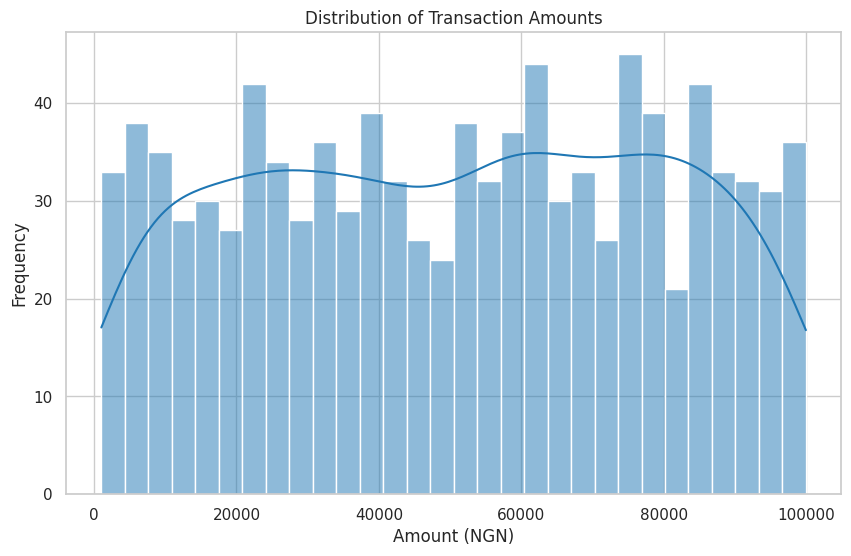

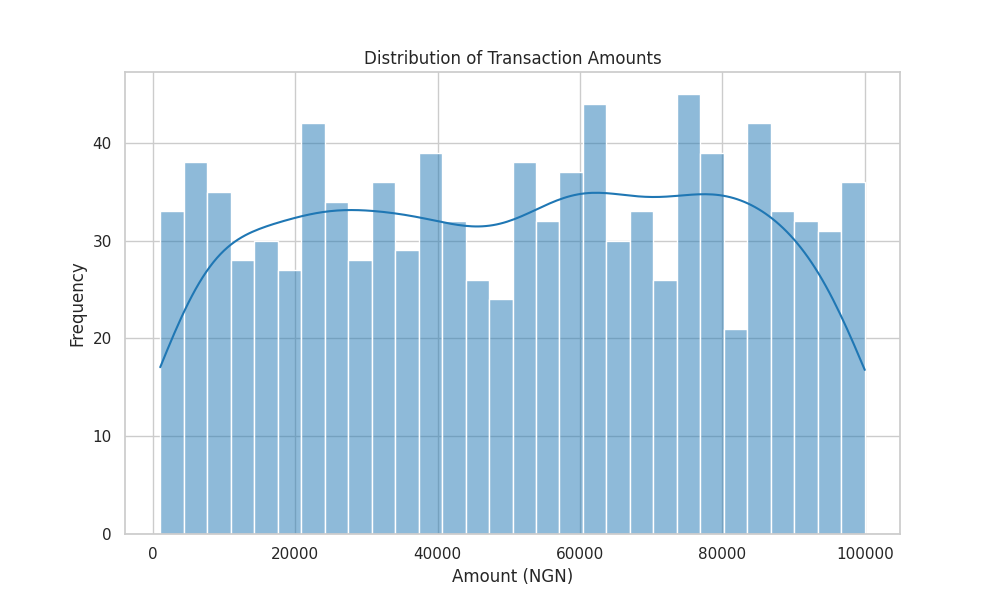

/tmp/ipython-input-27-3730631508.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='merchant_type', y='amount', data=df, palette='Set2')


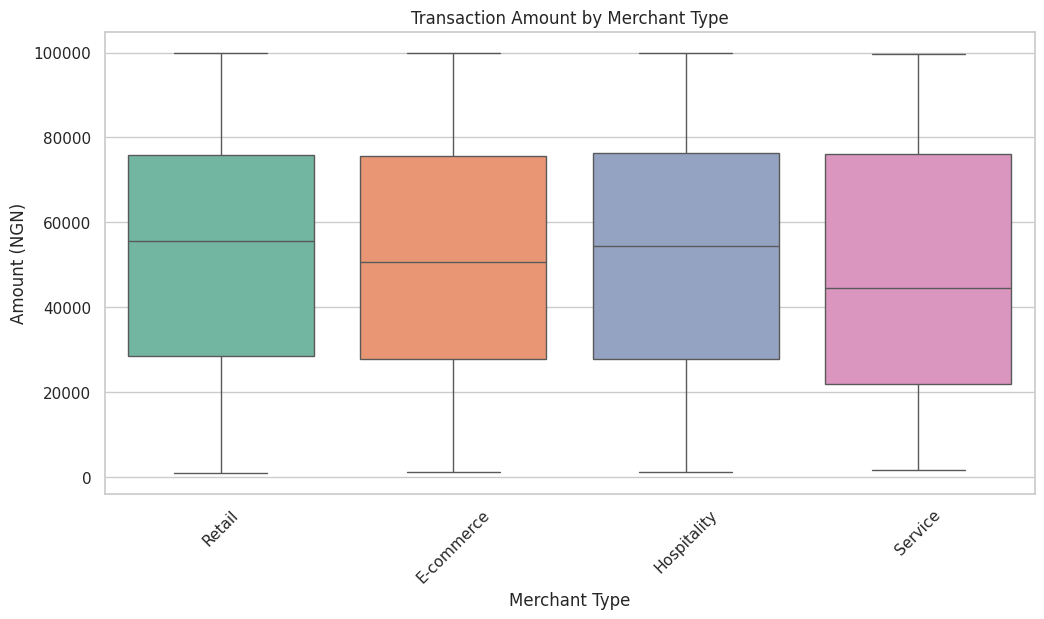

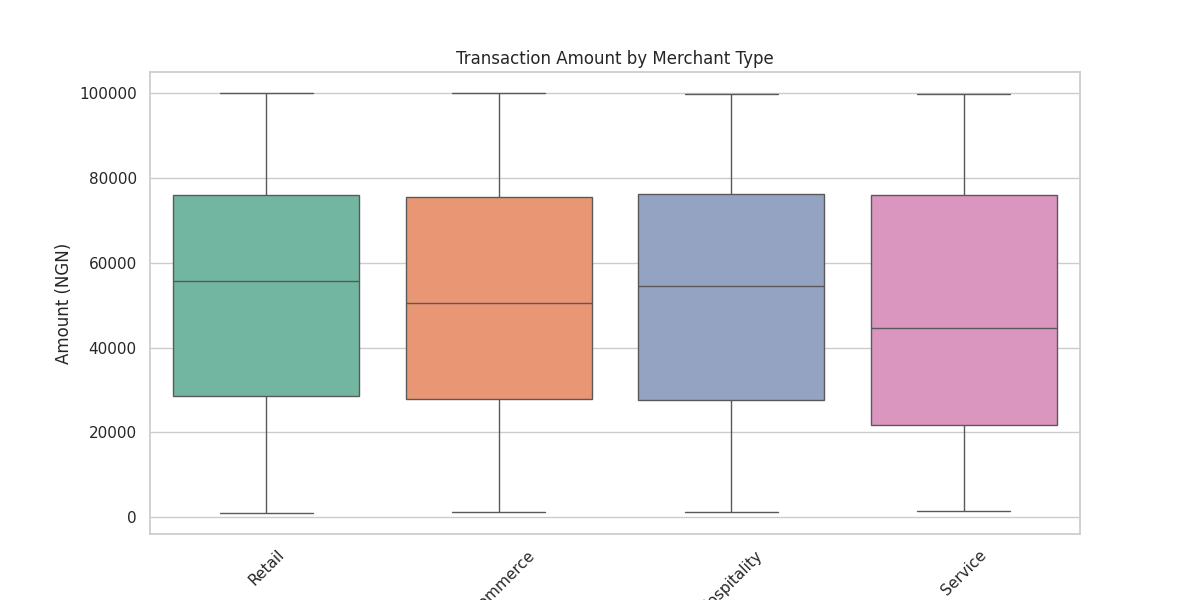

/tmp/ipython-input-27-3730631508.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='payment_method', y='amount', data=df, palette='Set3')


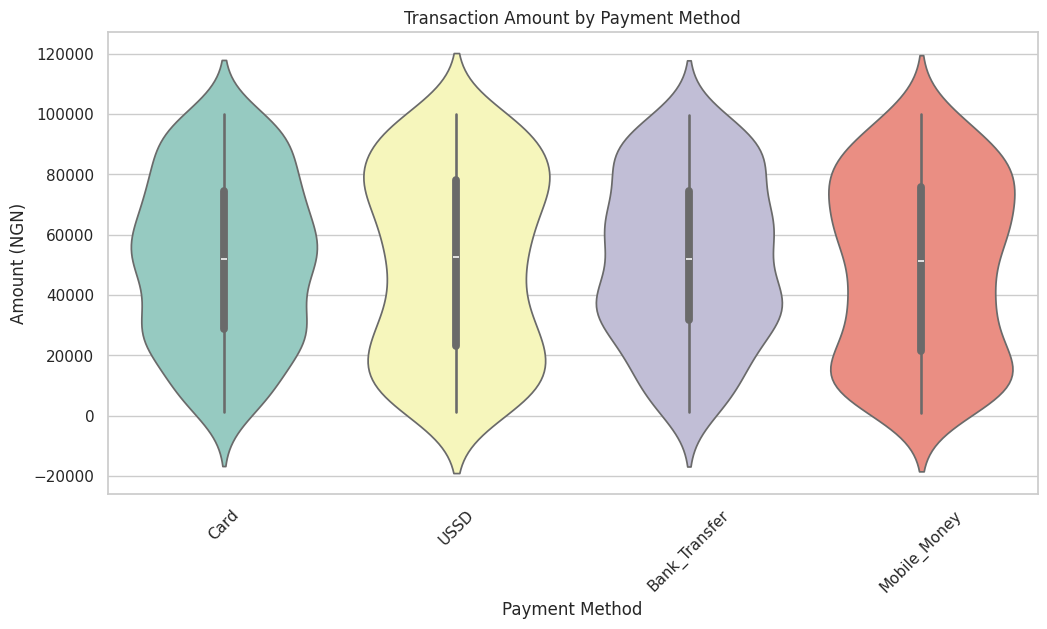

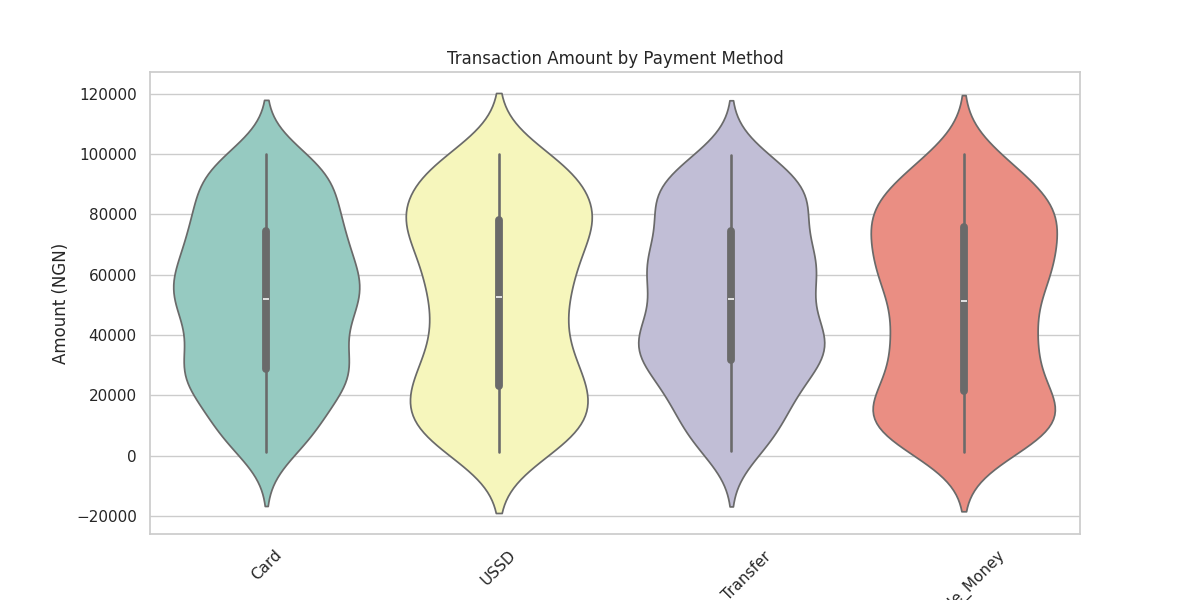

<Figure size 1000x800 with 0 Axes>

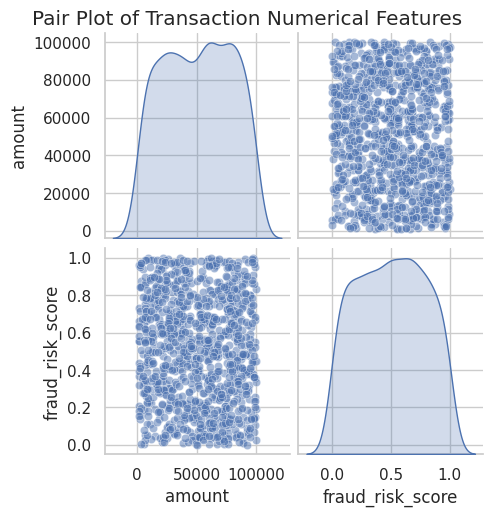

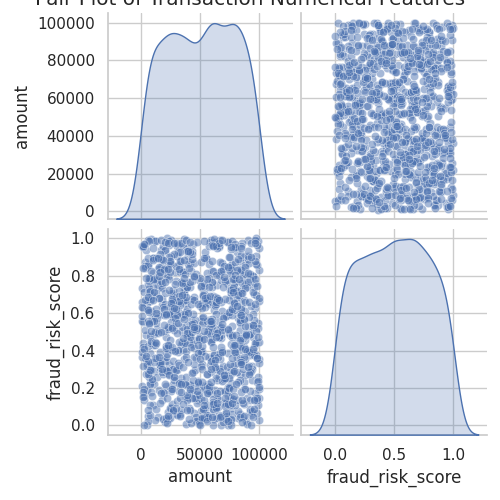

/tmp/ipython-input-27-3730631508.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette='Set1')


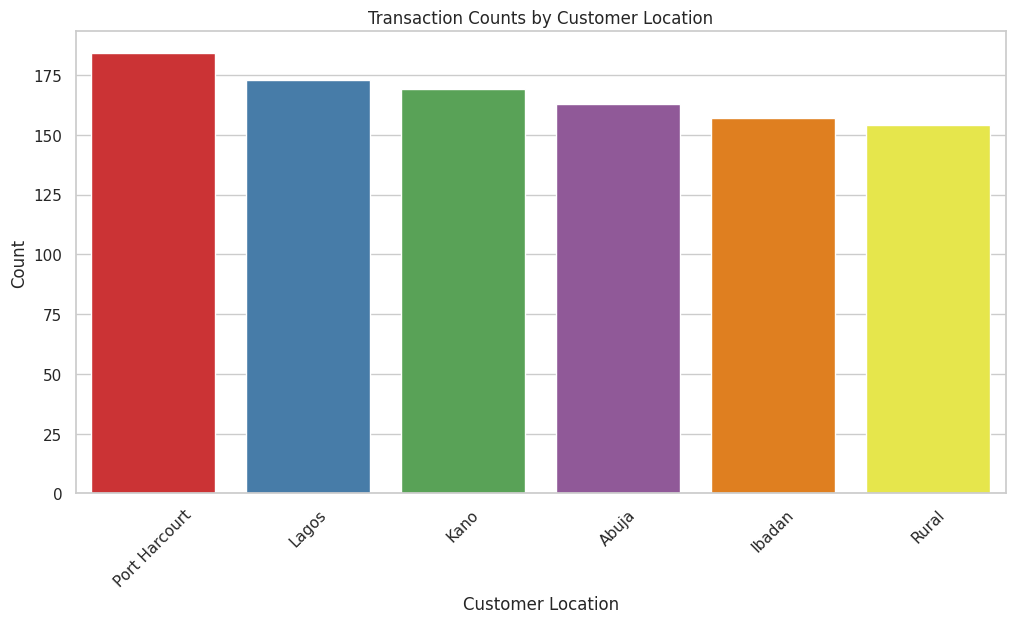

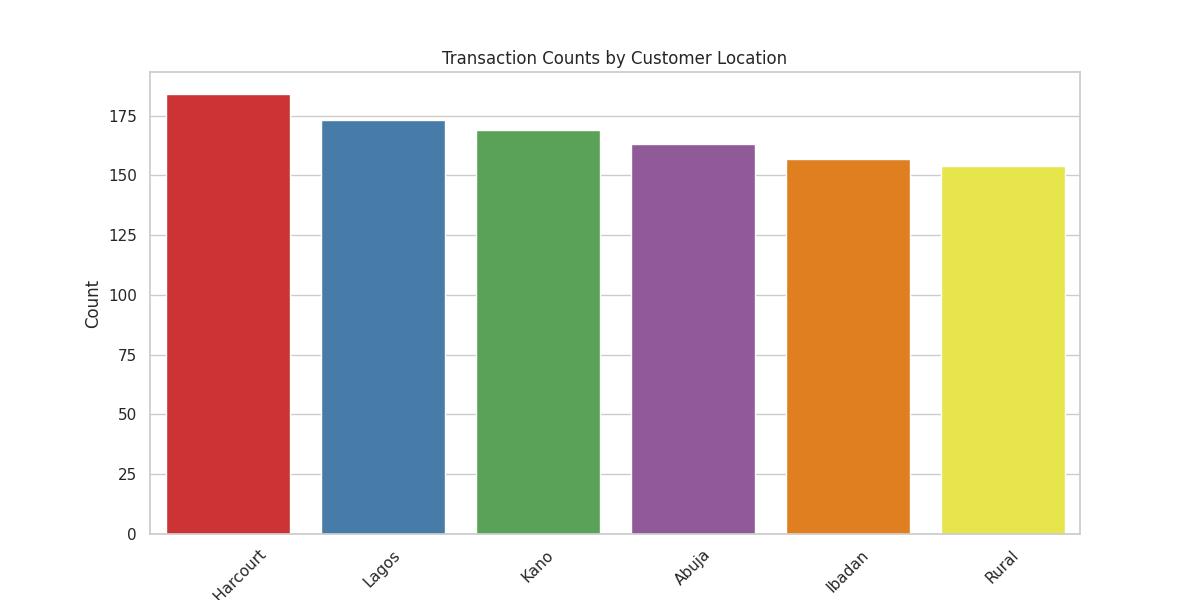

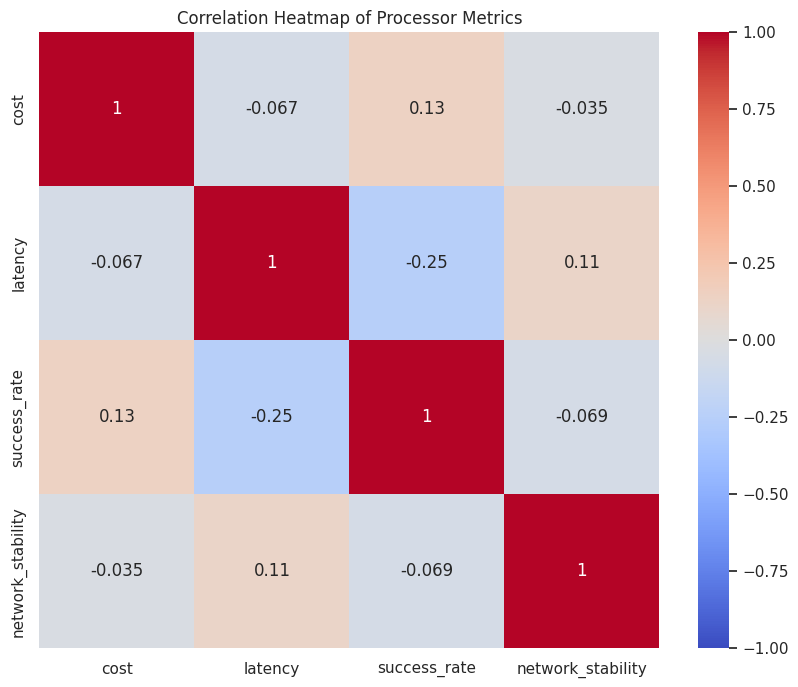

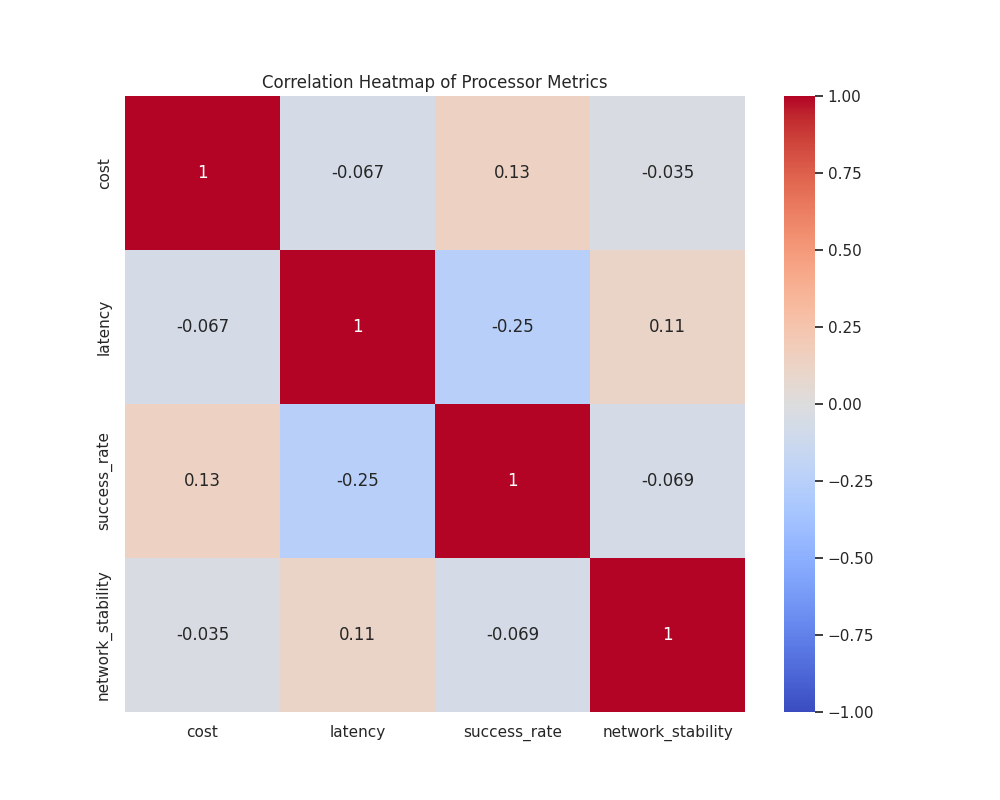

/tmp/ipython-input-27-3730631508.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='processor_pathway', y='latency', data=df, palette='Set3')


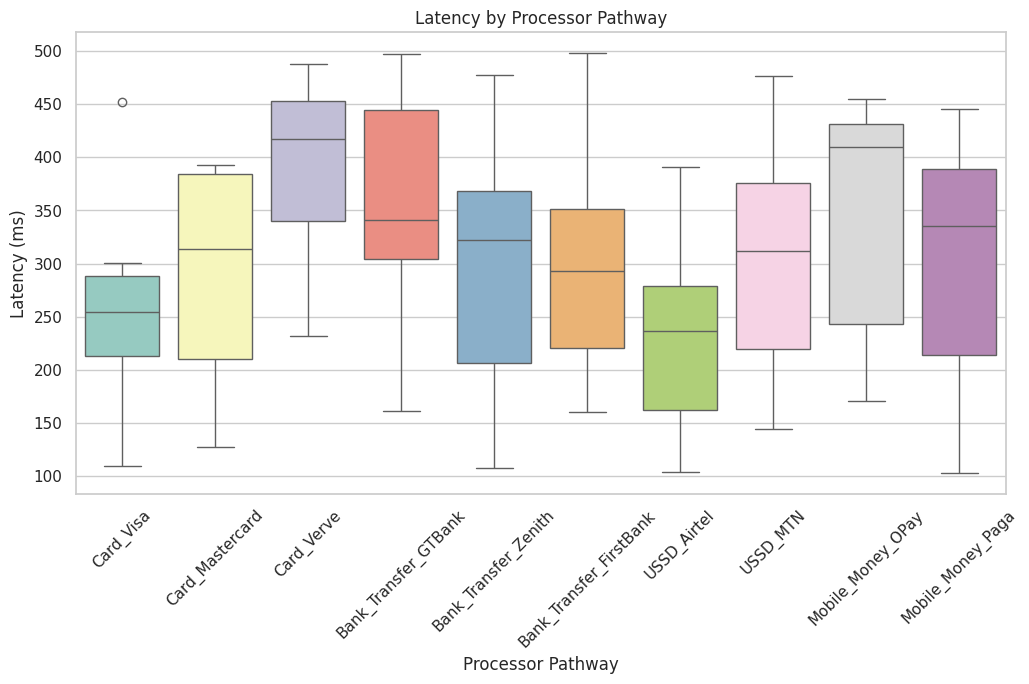

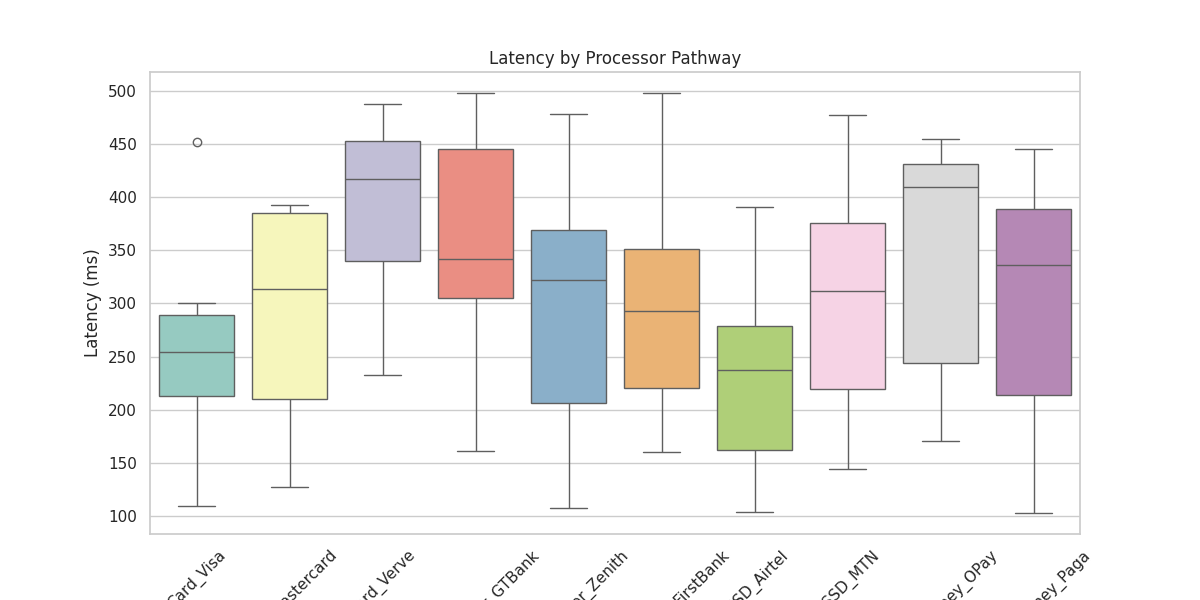

/tmp/ipython-input-27-3730631508.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='processor_pathway', y='success_rate', data=df, palette='Set2')


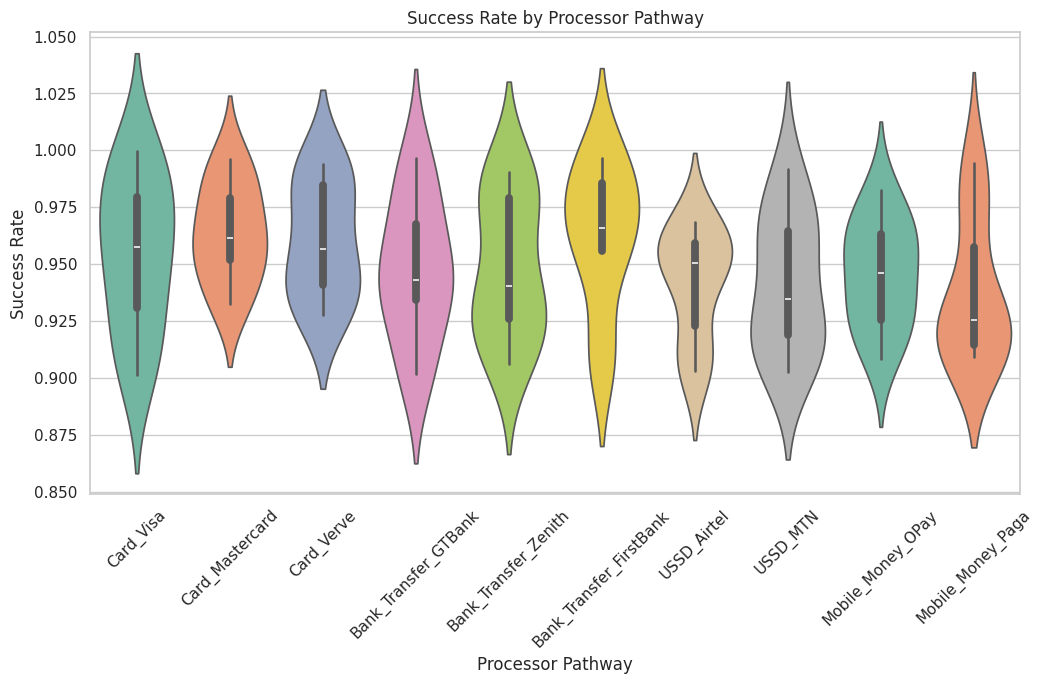

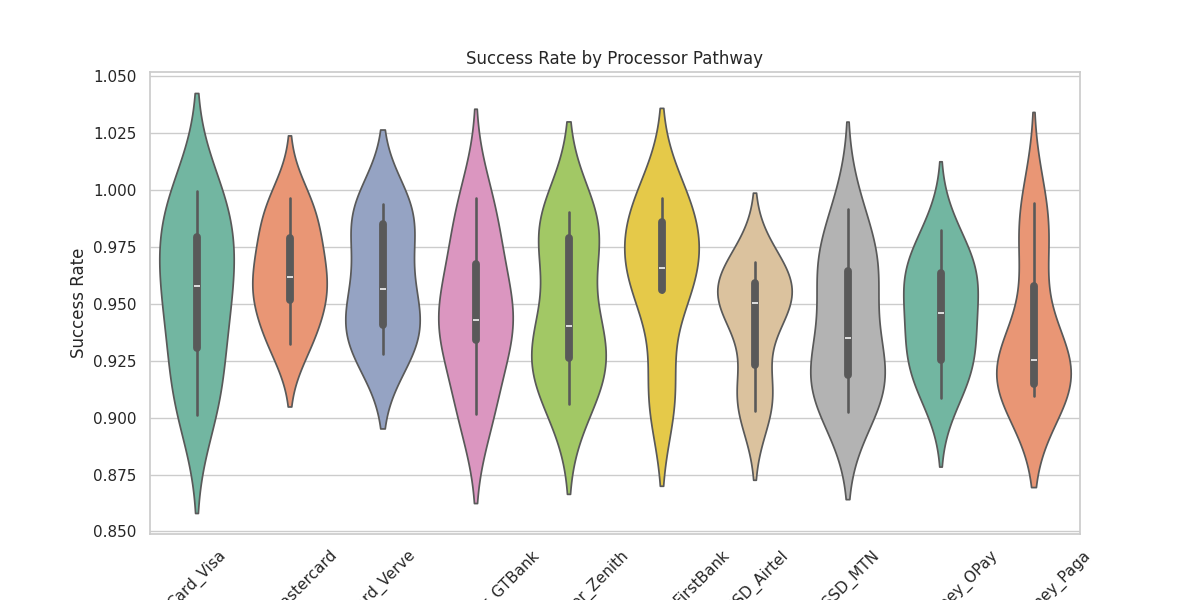

/tmp/ipython-input-27-3730631508.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pathway_counts.index, y=pathway_counts.values, palette='Set1')


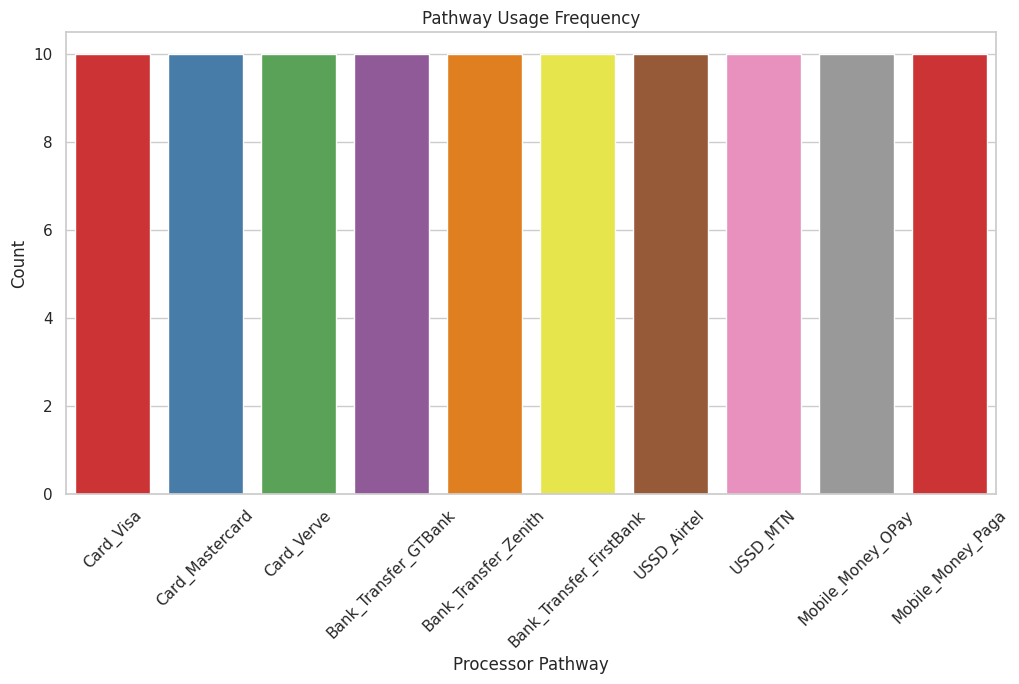

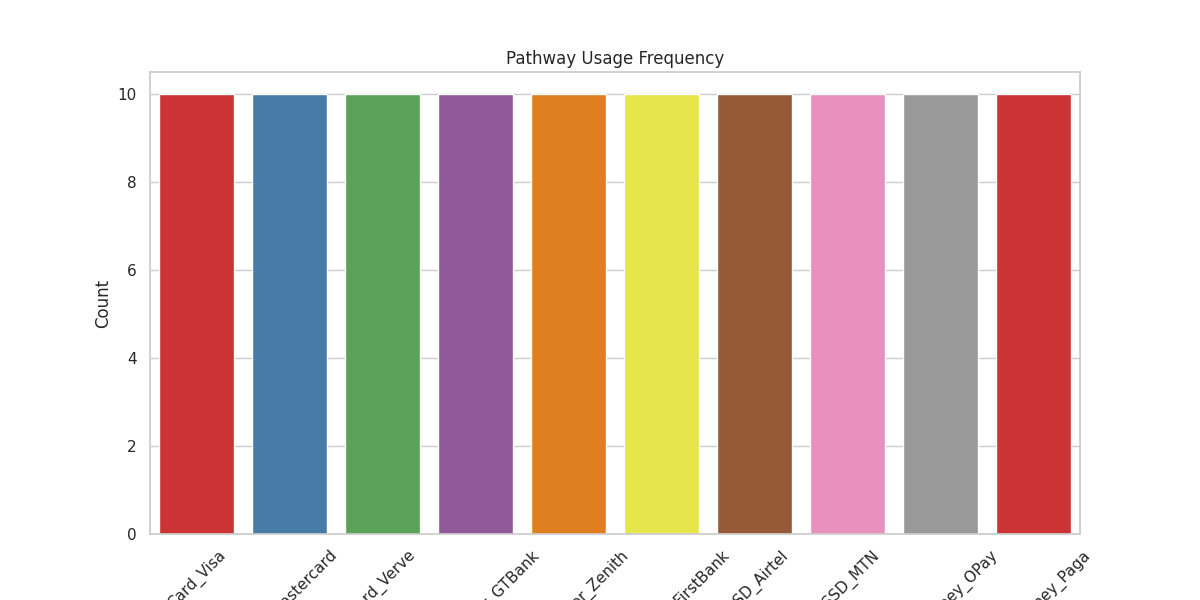

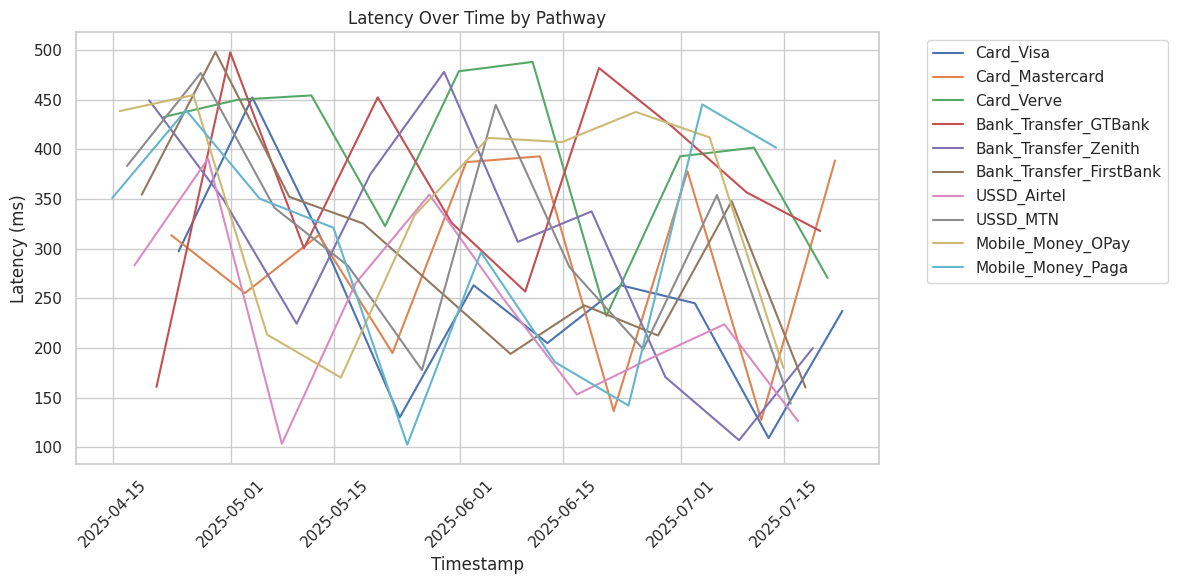

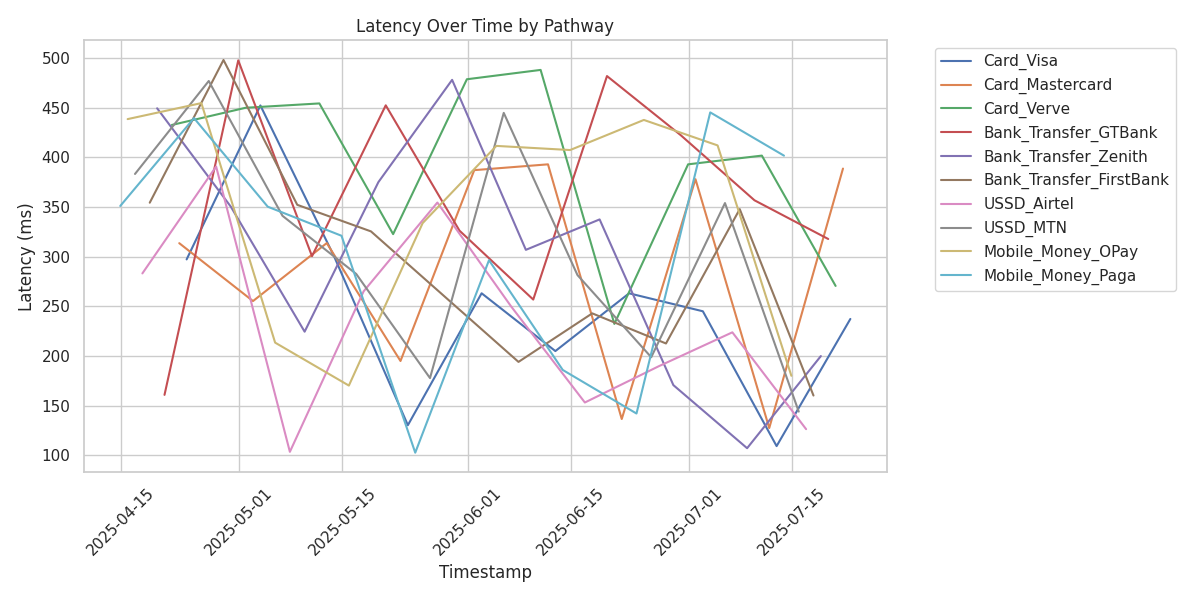

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/tmp/ipython-input-29-3702417637.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


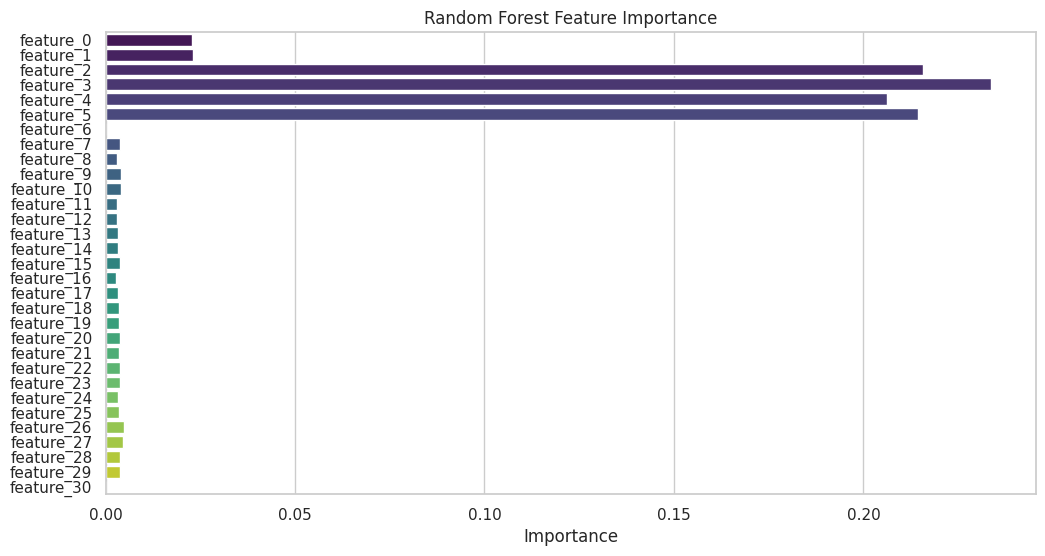

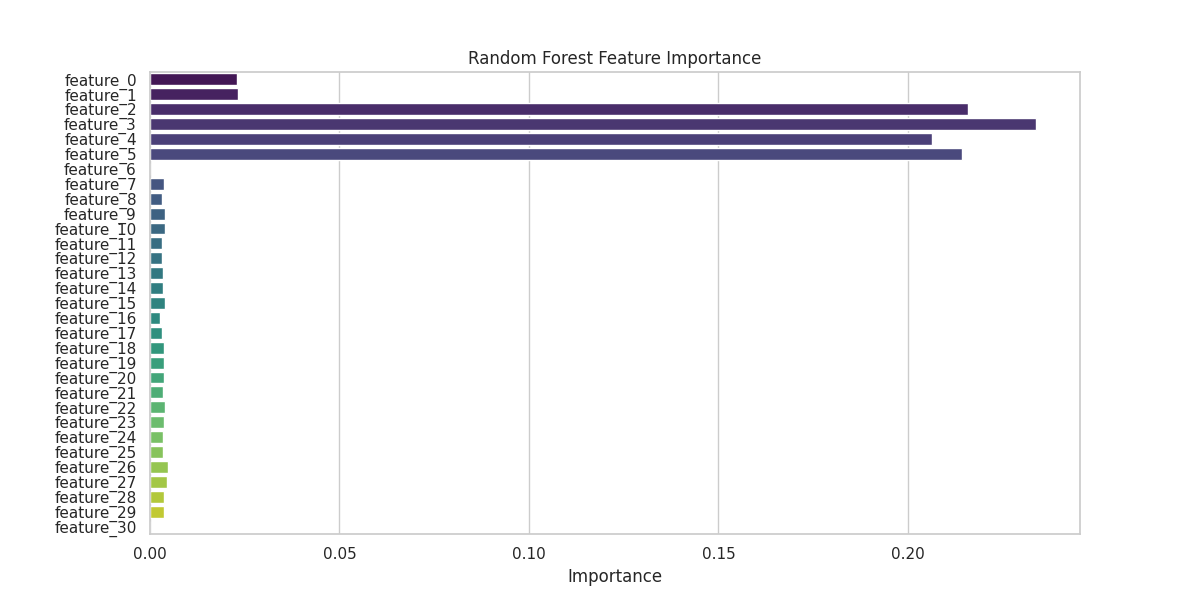

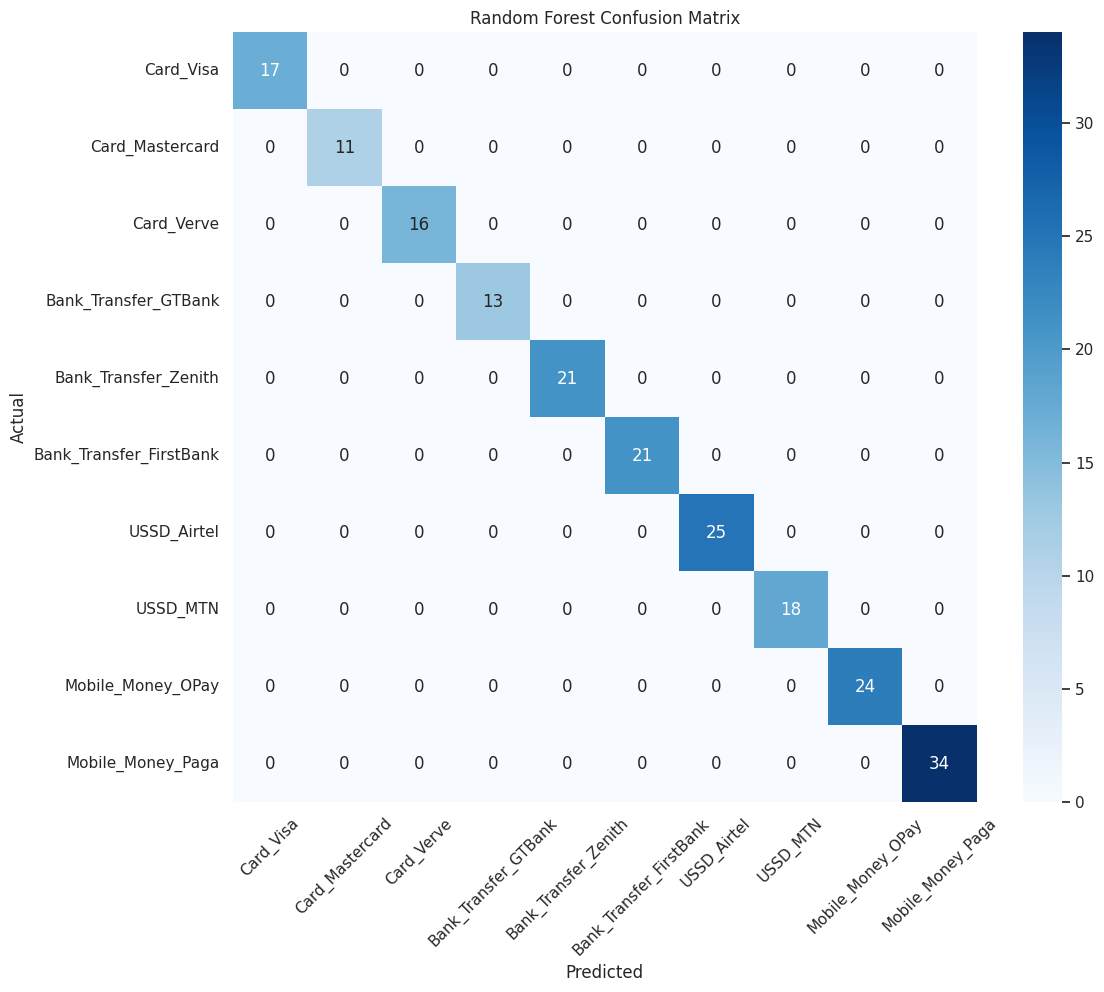

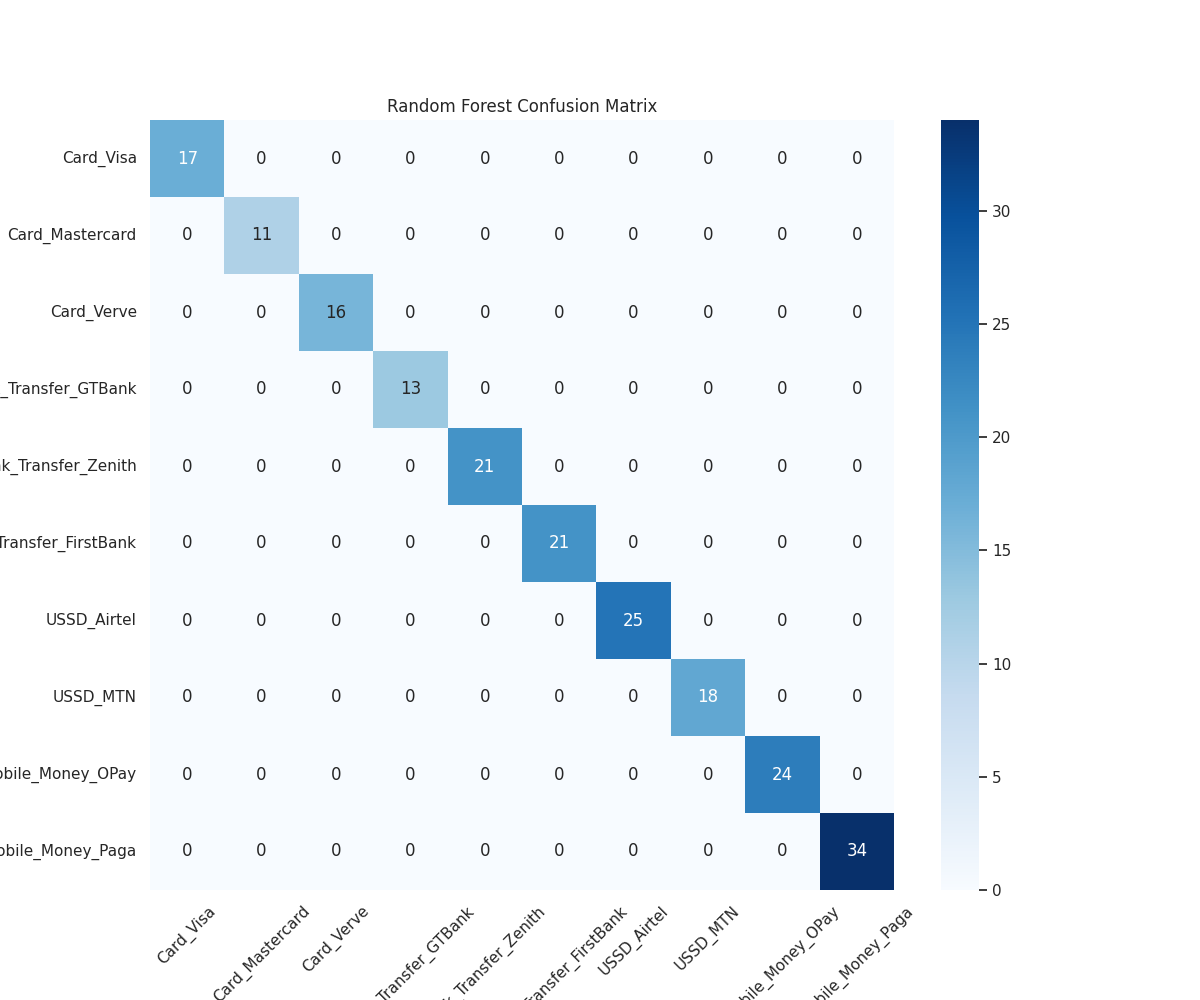

/tmp/ipython-input-29-3702417637.py:98: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(self.cb_rewards[pathway], label=pathway)


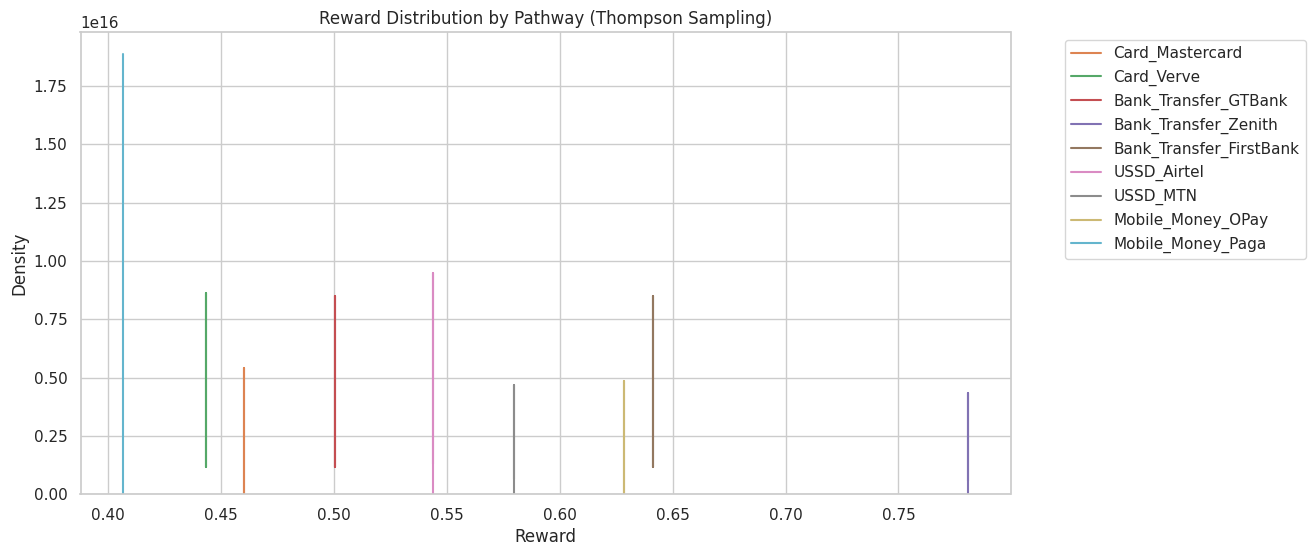

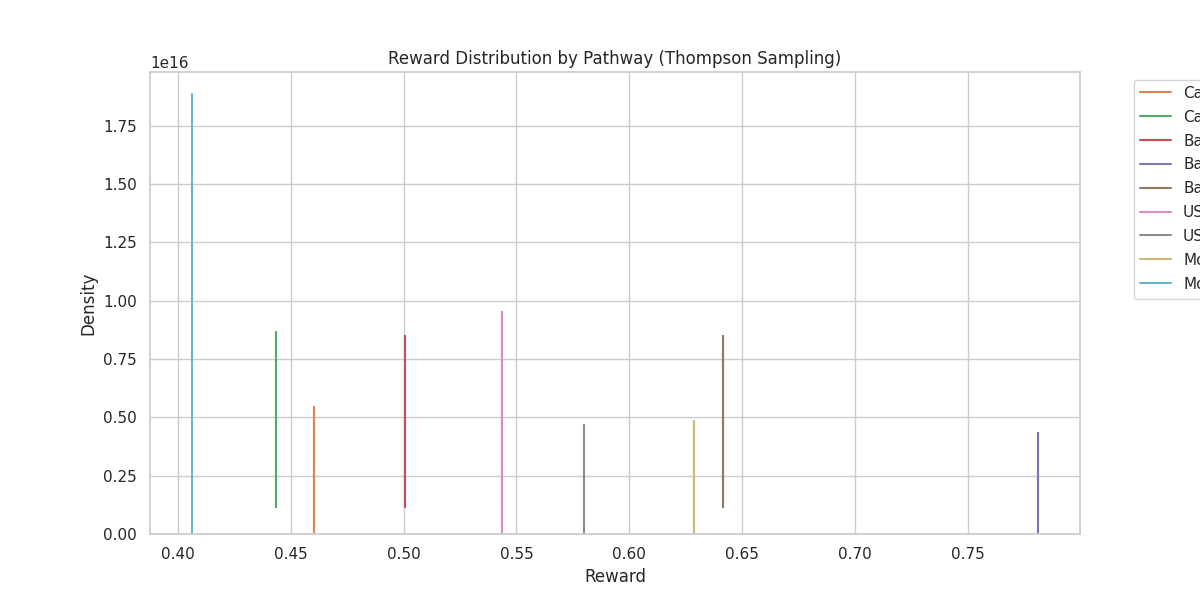

/tmp/ipython-input-29-3702417637.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=self.config.available_pathways, y=avg_rewards, palette='Set2')


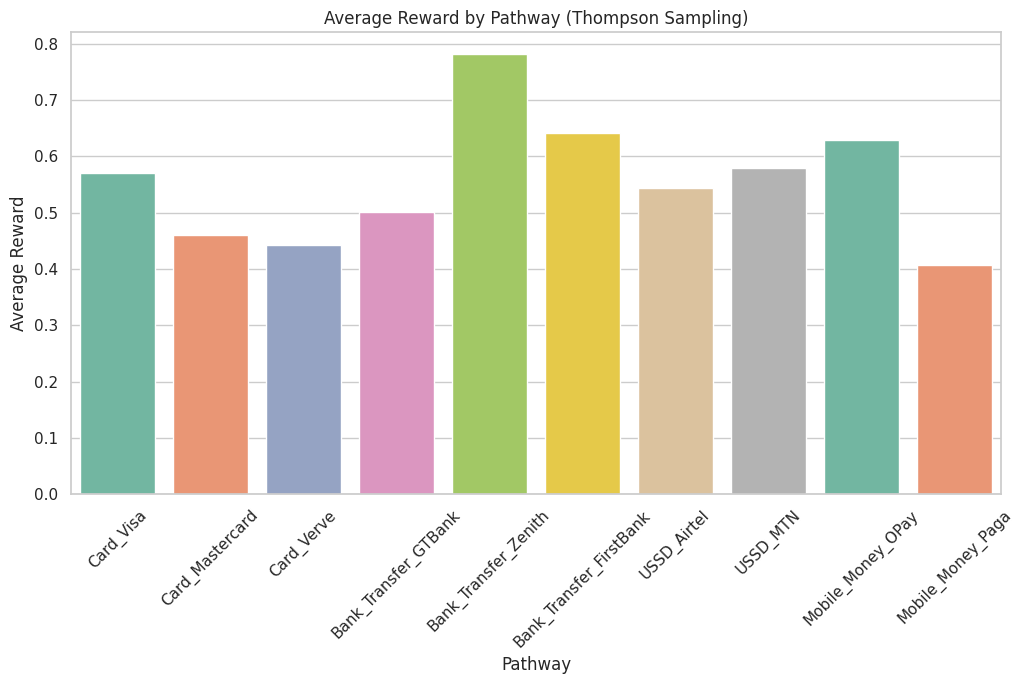

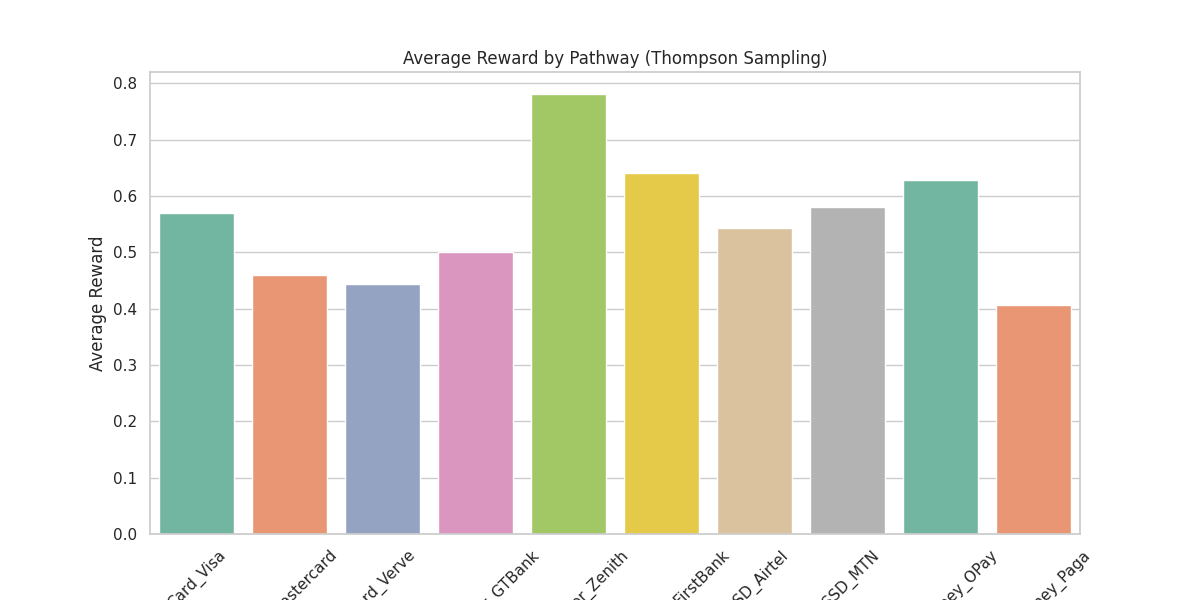

Displaying /content/transaction_amount_histogram.png


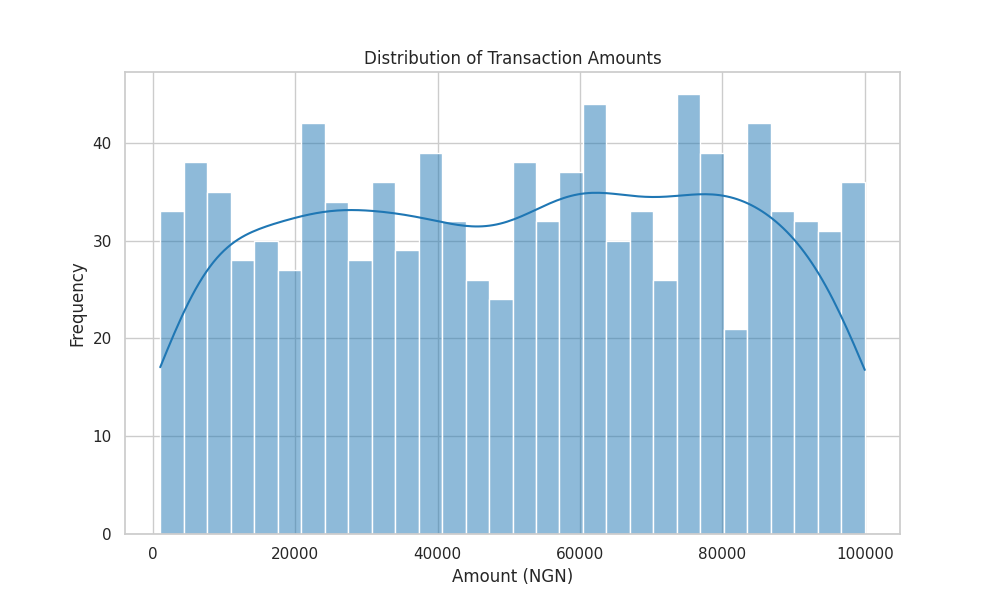

Displaying /content/amount_by_merchant_boxplot.png


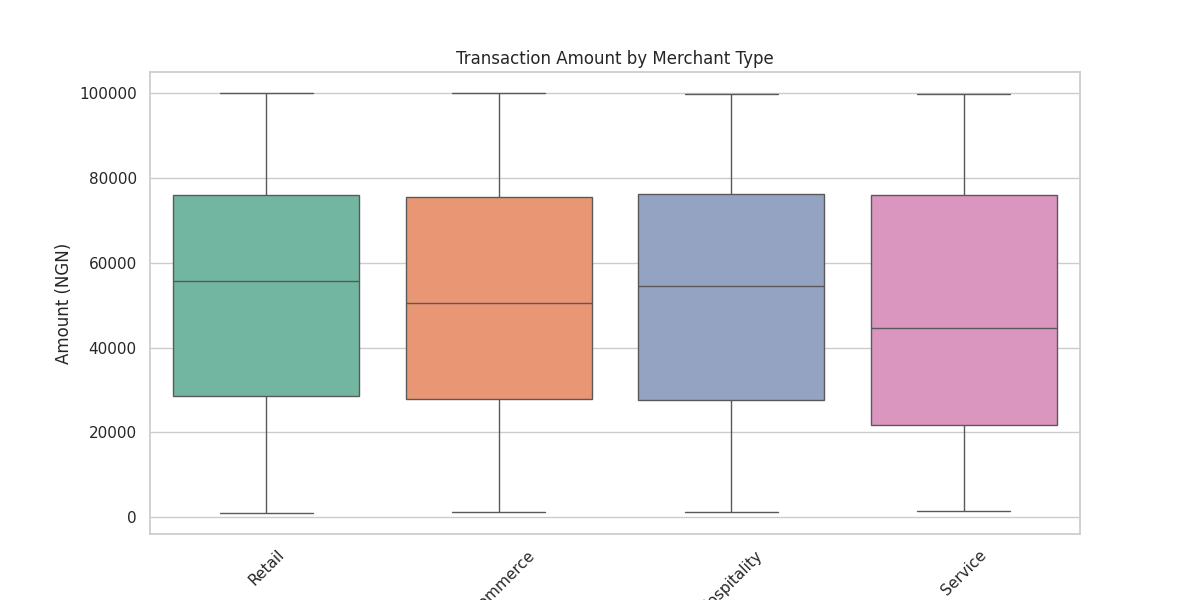

Displaying /content/amount_by_payment_violin.png


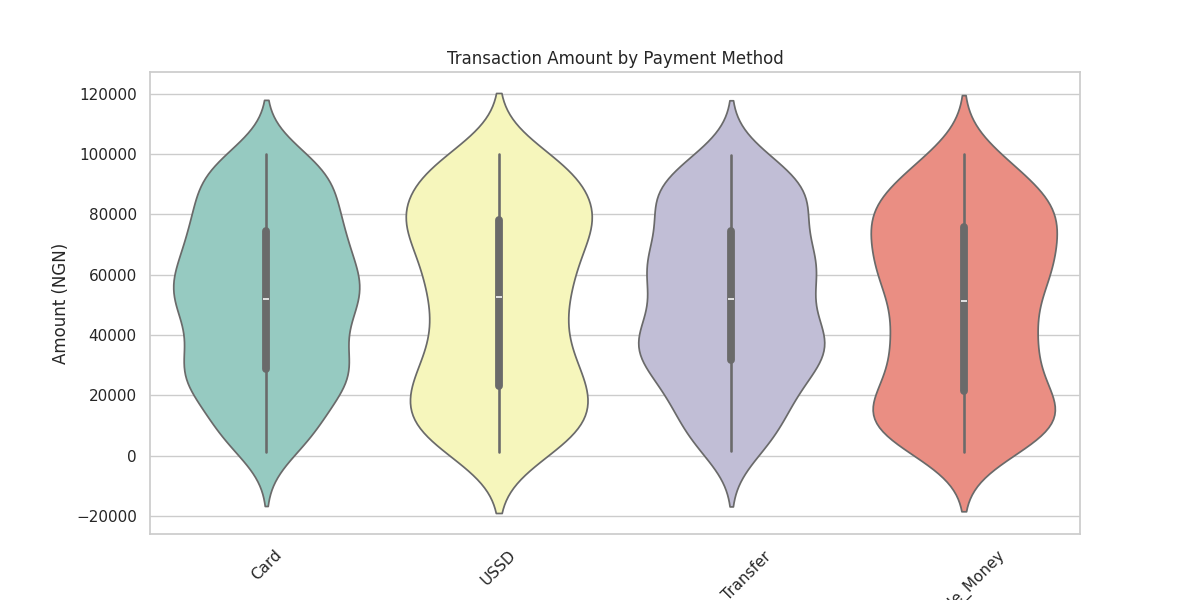

Displaying /content/transaction_pairplot.png


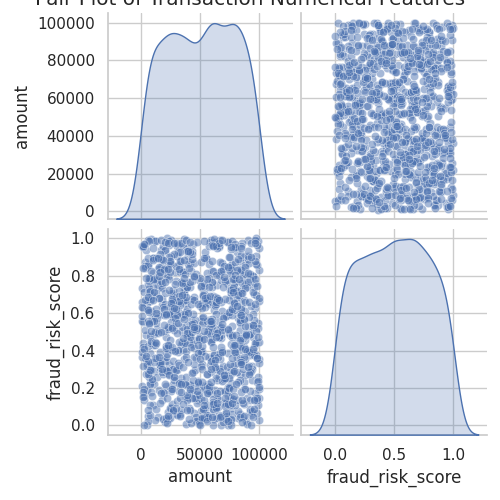

Displaying /content/transaction_location_bar.png


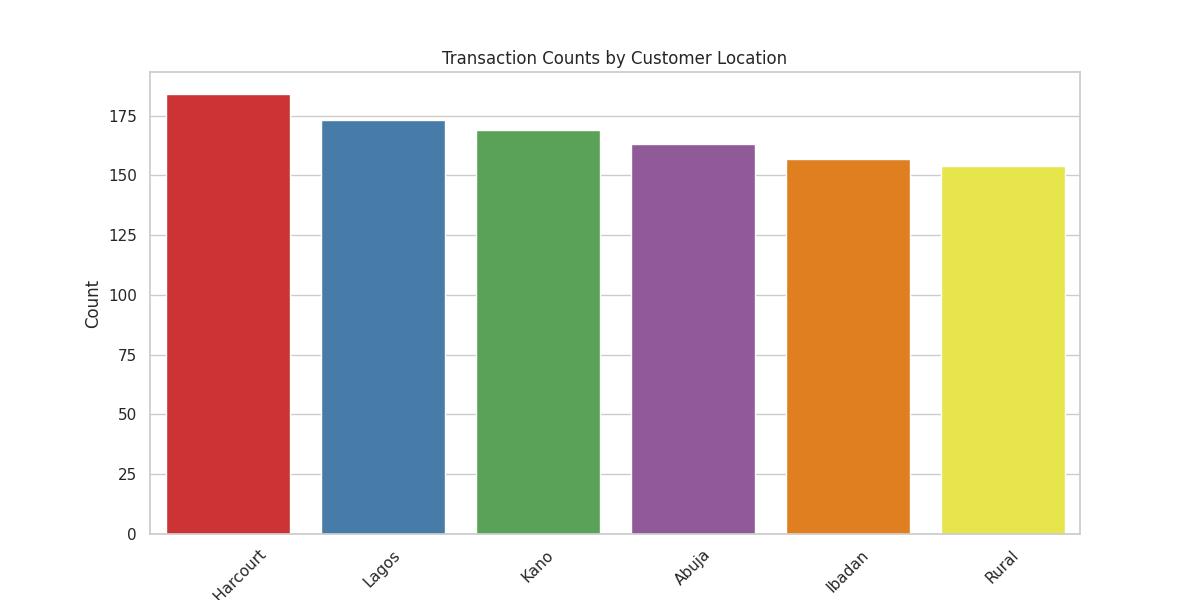

Displaying /content/metrics_correlation_heatmap.png


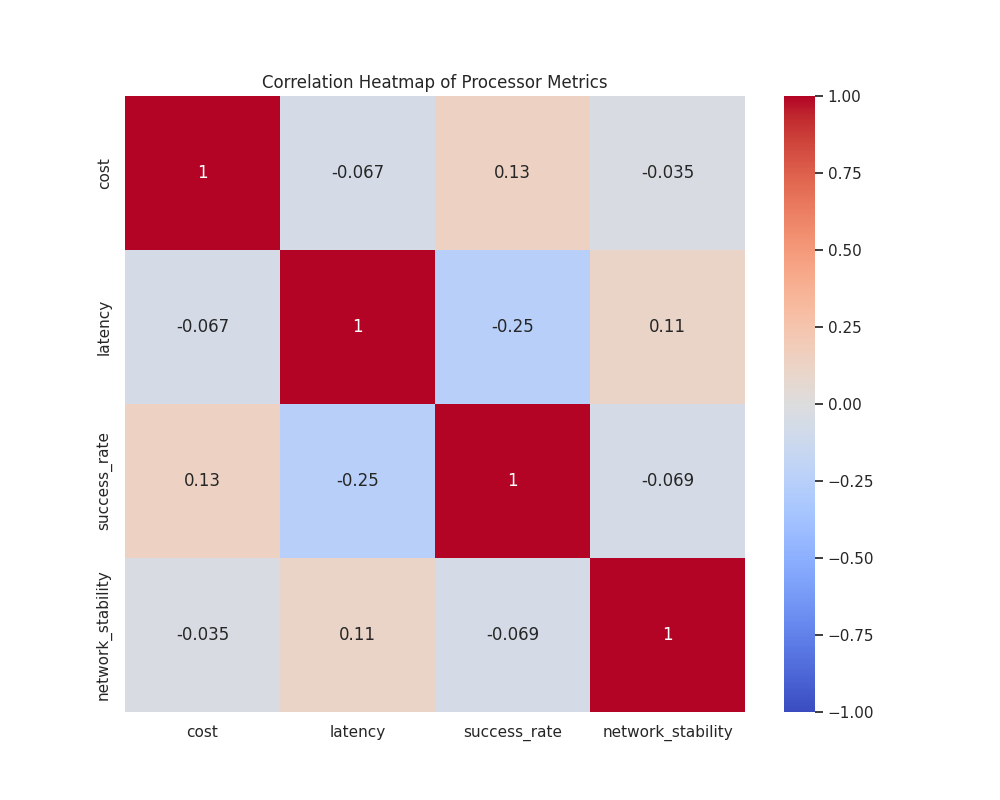

Displaying /content/latency_by_pathway_boxplot.png


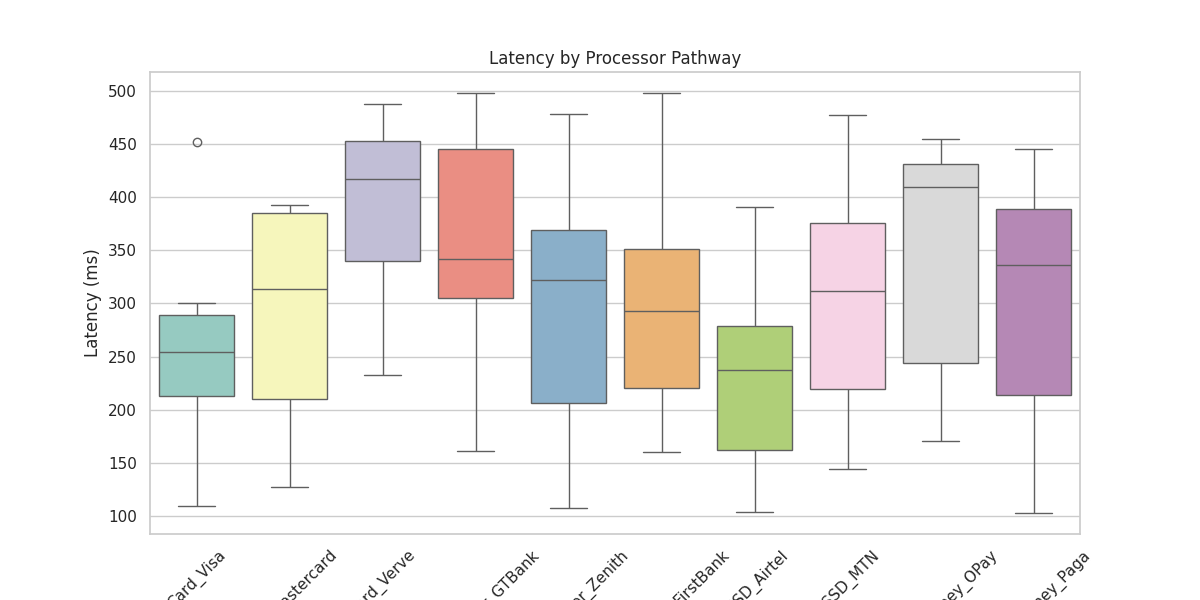

Displaying /content/success_rate_by_pathway_violin.png


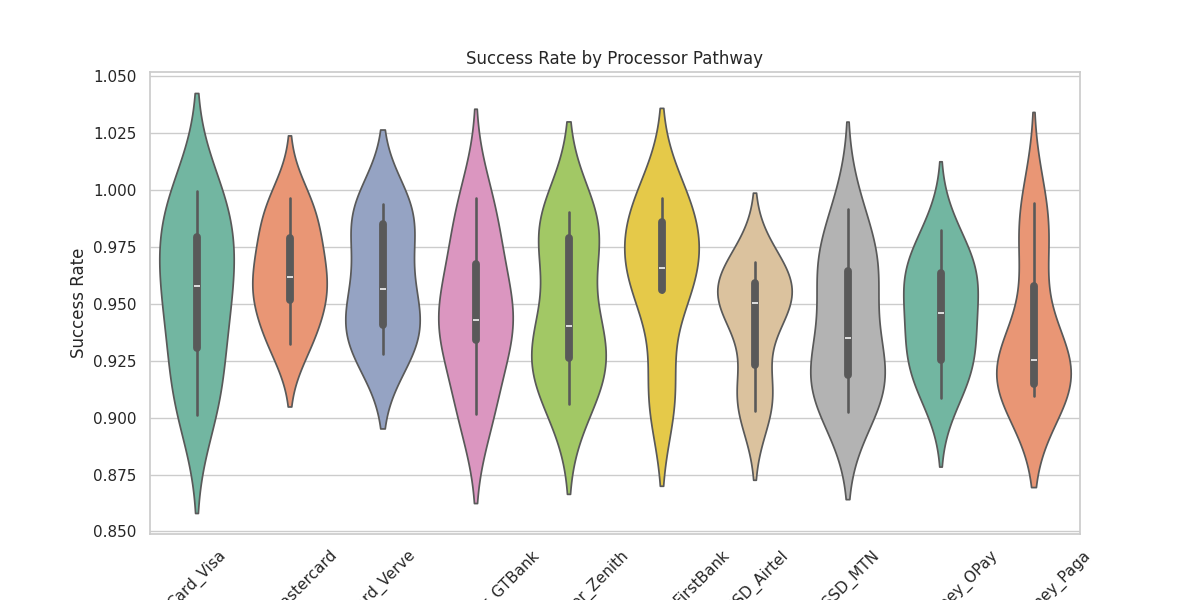

Displaying /content/pathway_usage_bar.png


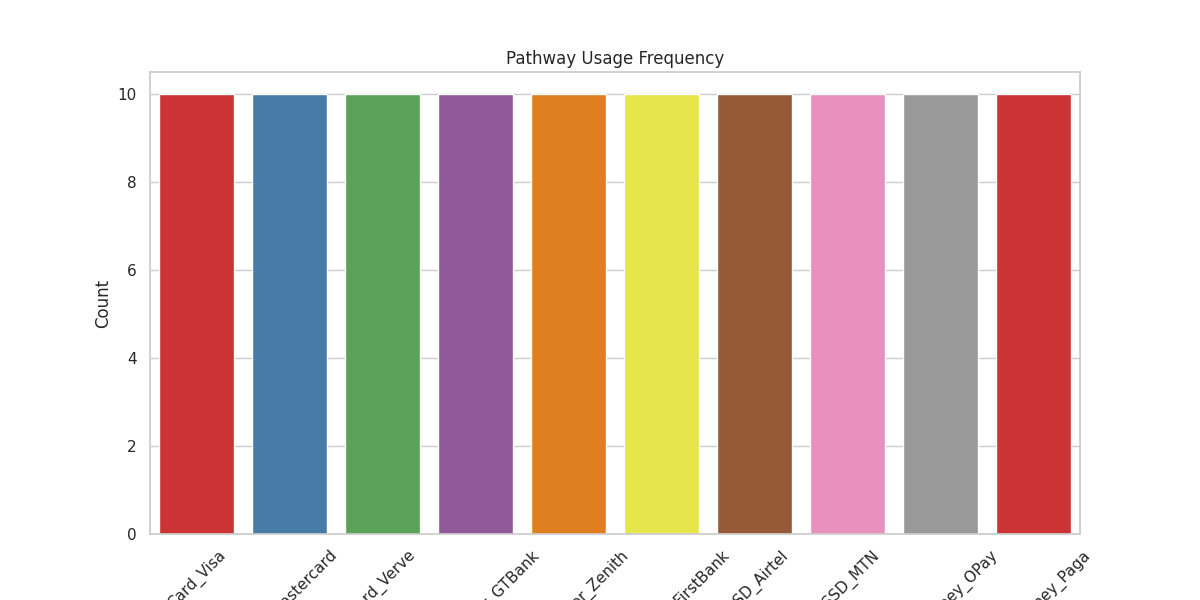

Displaying /content/latency_time_series.png


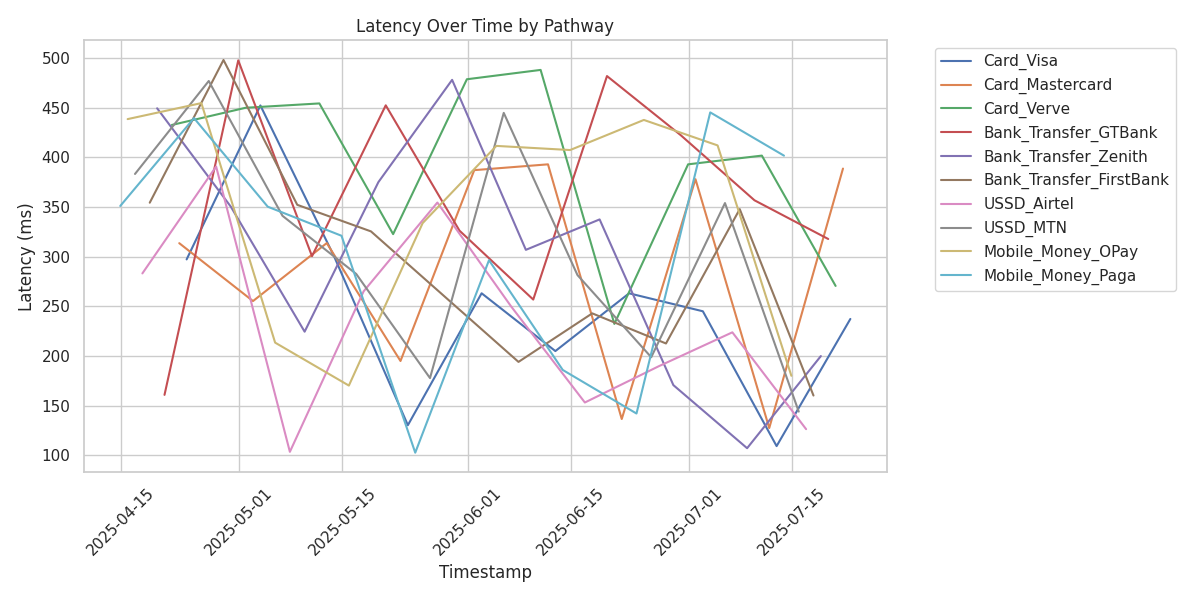

Displaying /content/rf_feature_importance.png


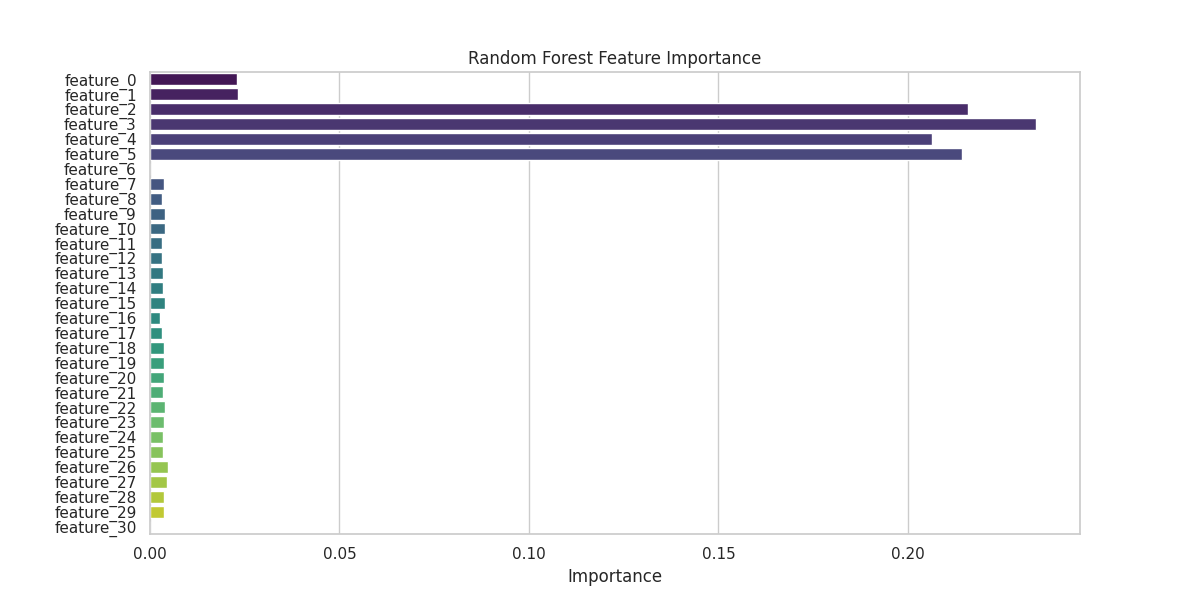

Displaying /content/rf_confusion_matrix.png


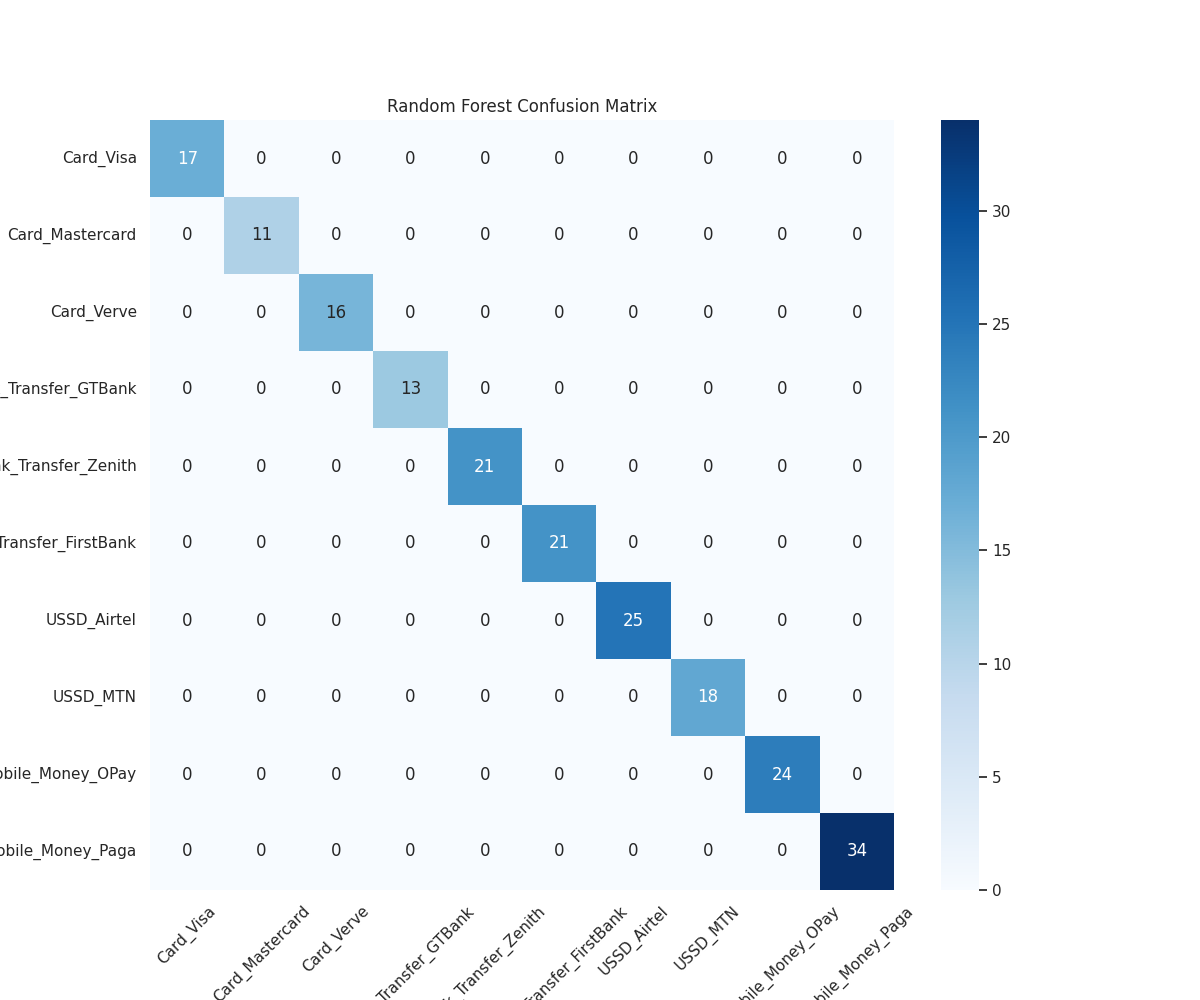

Displaying /content/cb_reward_distribution.png


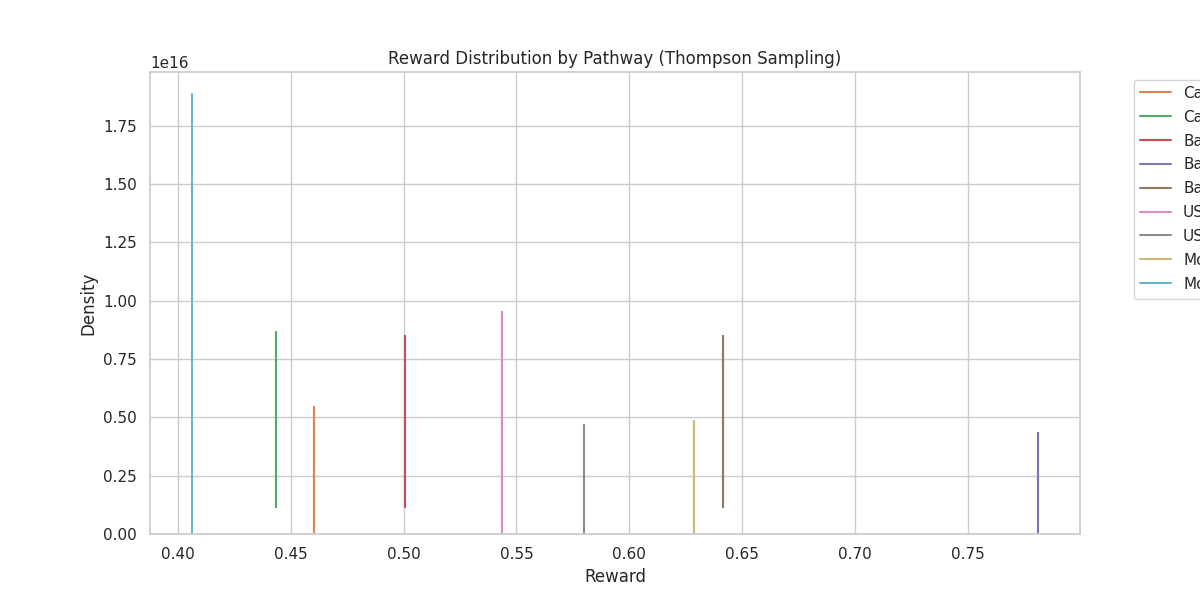

Displaying /content/cb_reward_bar.png


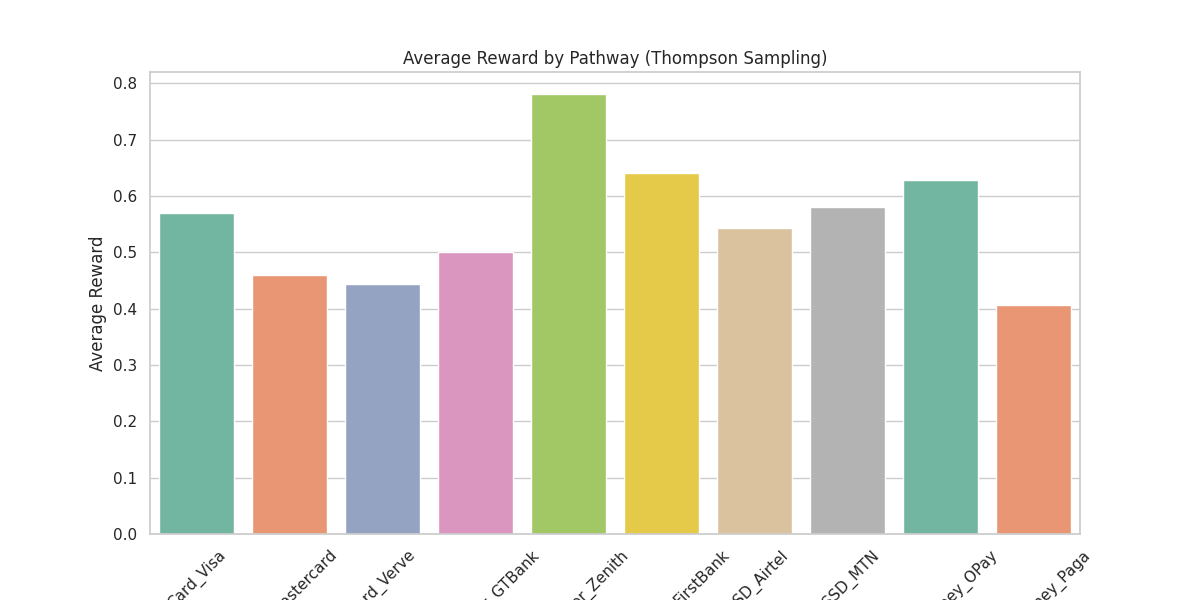

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Gradio interface launched. Access it above to test the payment routing system.


In [35]:
def display_images():

    image_files = [
        '/content/transaction_amount_histogram.png',
        '/content/amount_by_merchant_boxplot.png',
        '/content/amount_by_payment_violin.png',
        '/content/transaction_pairplot.png',
        '/content/transaction_location_bar.png',
        '/content/metrics_correlation_heatmap.png',
        '/content/latency_by_pathway_boxplot.png',
        '/content/success_rate_by_pathway_violin.png',
        '/content/pathway_usage_bar.png',
        '/content/latency_time_series.png',
        '/content/rf_feature_importance.png',
        '/content/rf_confusion_matrix.png',
        '/content/cb_reward_distribution.png',
        '/content/cb_reward_bar.png'
    ]
    for img in image_files:
        if os.path.exists(img):
            print(f"Displaying {img}")
            display(Image(filename=img))
        else:
            logger.warning(f"Image not found: {img}")

if __name__ == "__main__":
    try:
        system = PaymentRoutingSystem()
        system.initialize()
        display_images()
        iface = create_gui(system)
        iface.launch(share=False)
        print("Gradio interface launched. Access it above to test the payment routing system.")
    except Exception as e:
        logger.error(f"System startup failed: {e}")
        raise